# MMM Example Notebook

In this notebook we work out a simulated example to showcase the MMM API from `pymc-marketing`. The data generation process is as an adaptation of the blog post [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

---
# Part I: Data Generation Process

For this example we use simulated data.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import MaxAbsScaler,  MinMaxScaler
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

### 1. Date Range

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]

### 2. Media Costs Data

- Raw Signal

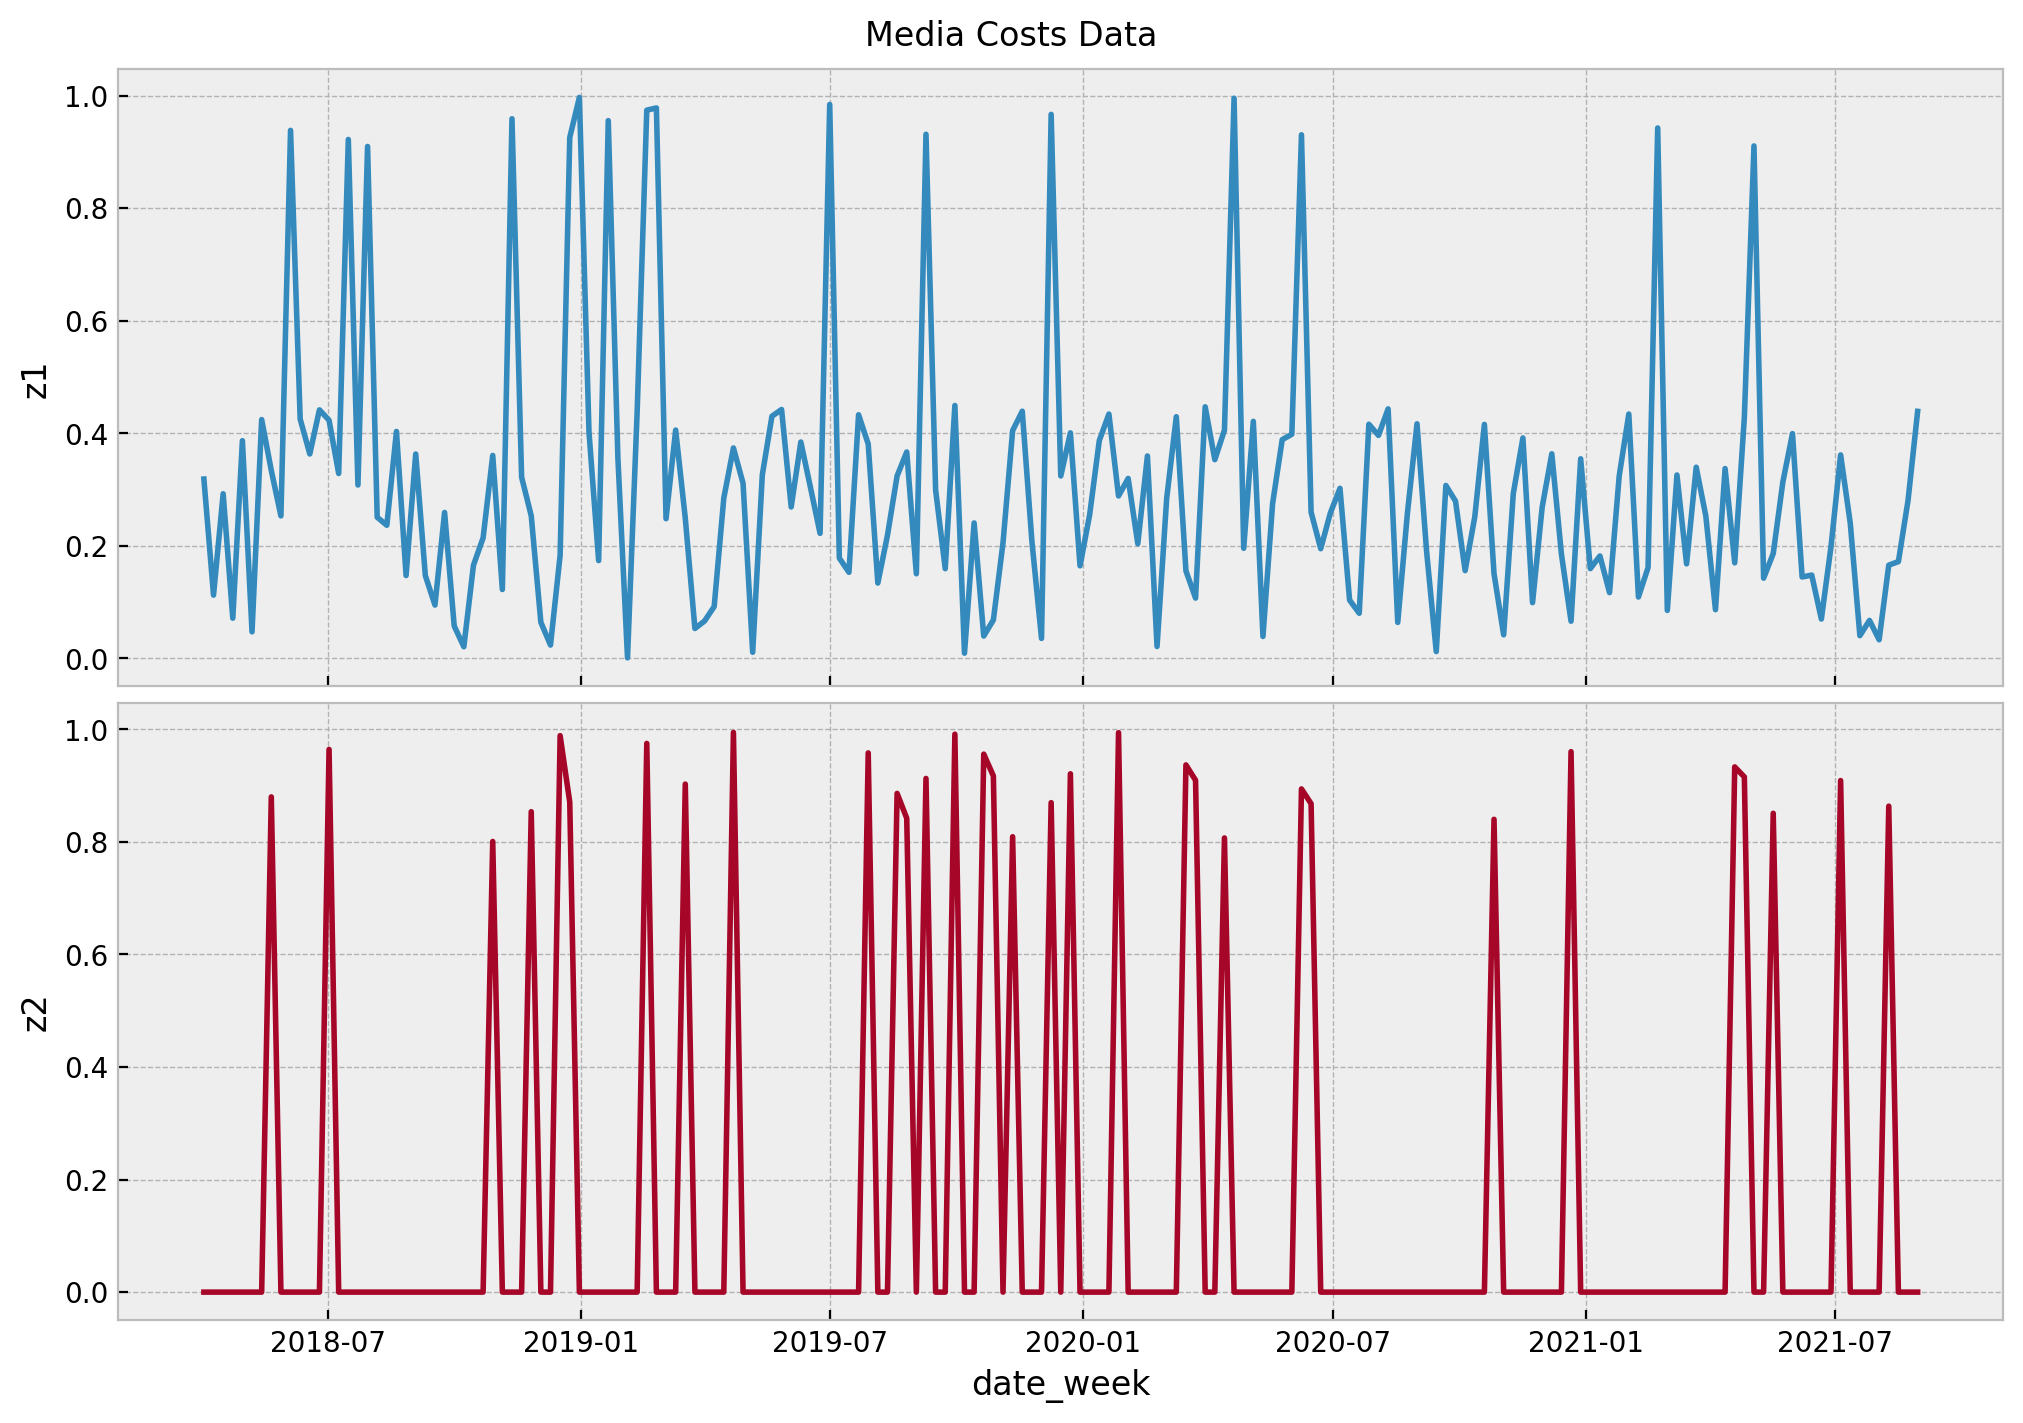

In [3]:
# media data
z1 = rng.uniform(low=0.0, high=1.0, size=n)
df["z1"] = np.where(z1 > 0.9, z1, z1 / 2)

z2 = rng.uniform(low=0.0, high=1.0, size=n)
df["z2"] = np.where(z2 > 0.8, z2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=df, color="C1", ax=ax[1])
fig.suptitle("Media Costs Data");

- Effect Signal

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["z1_adstock"] = (
    geometric_adstock(
        x=df["z1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

df["z2_adstock"] = (
    geometric_adstock(
        x=df["z2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True
    )
    .eval()
    .flatten()
)

# apply saturation transformation
lam1: float = 2
lam2: float = 1.5

df["z1_adstock_saturated"] = logistic_saturation(
    x=df["z1_adstock"].to_numpy(), lam=lam1
).eval()

df["z2_adstock_saturated"] = logistic_saturation(
    x=df["z2_adstock"].to_numpy(), lam=lam2
).eval()

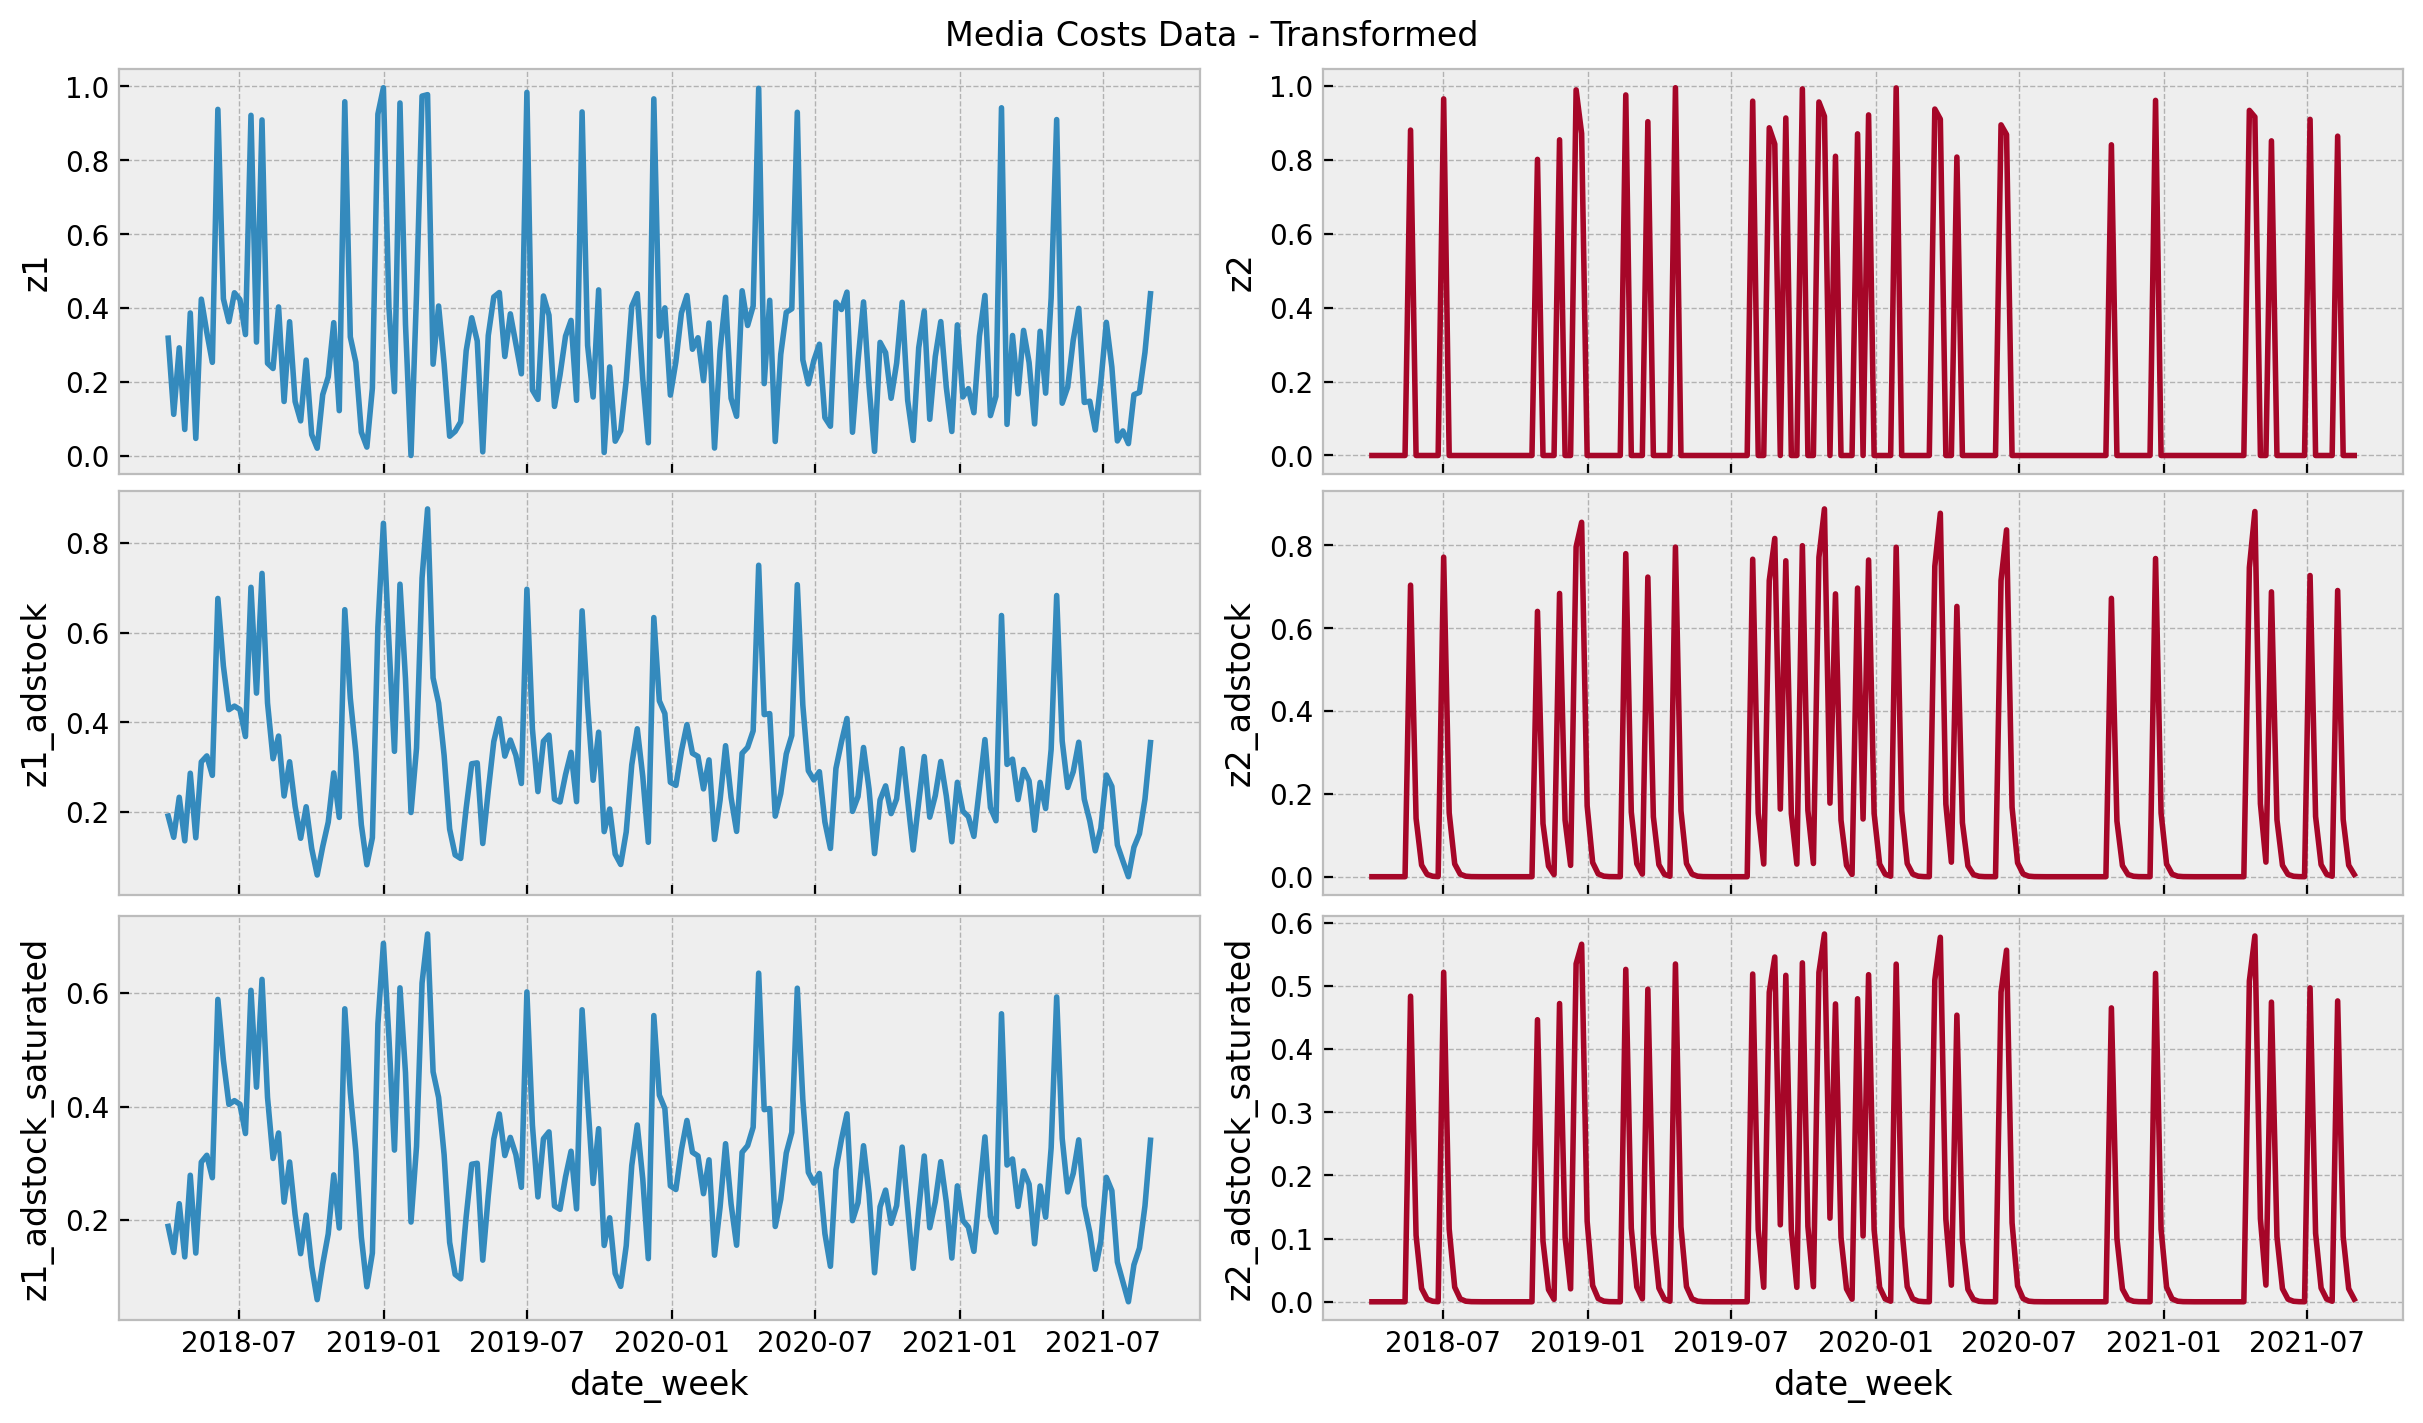

In [5]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed");

### Trend \& Seasonal Components

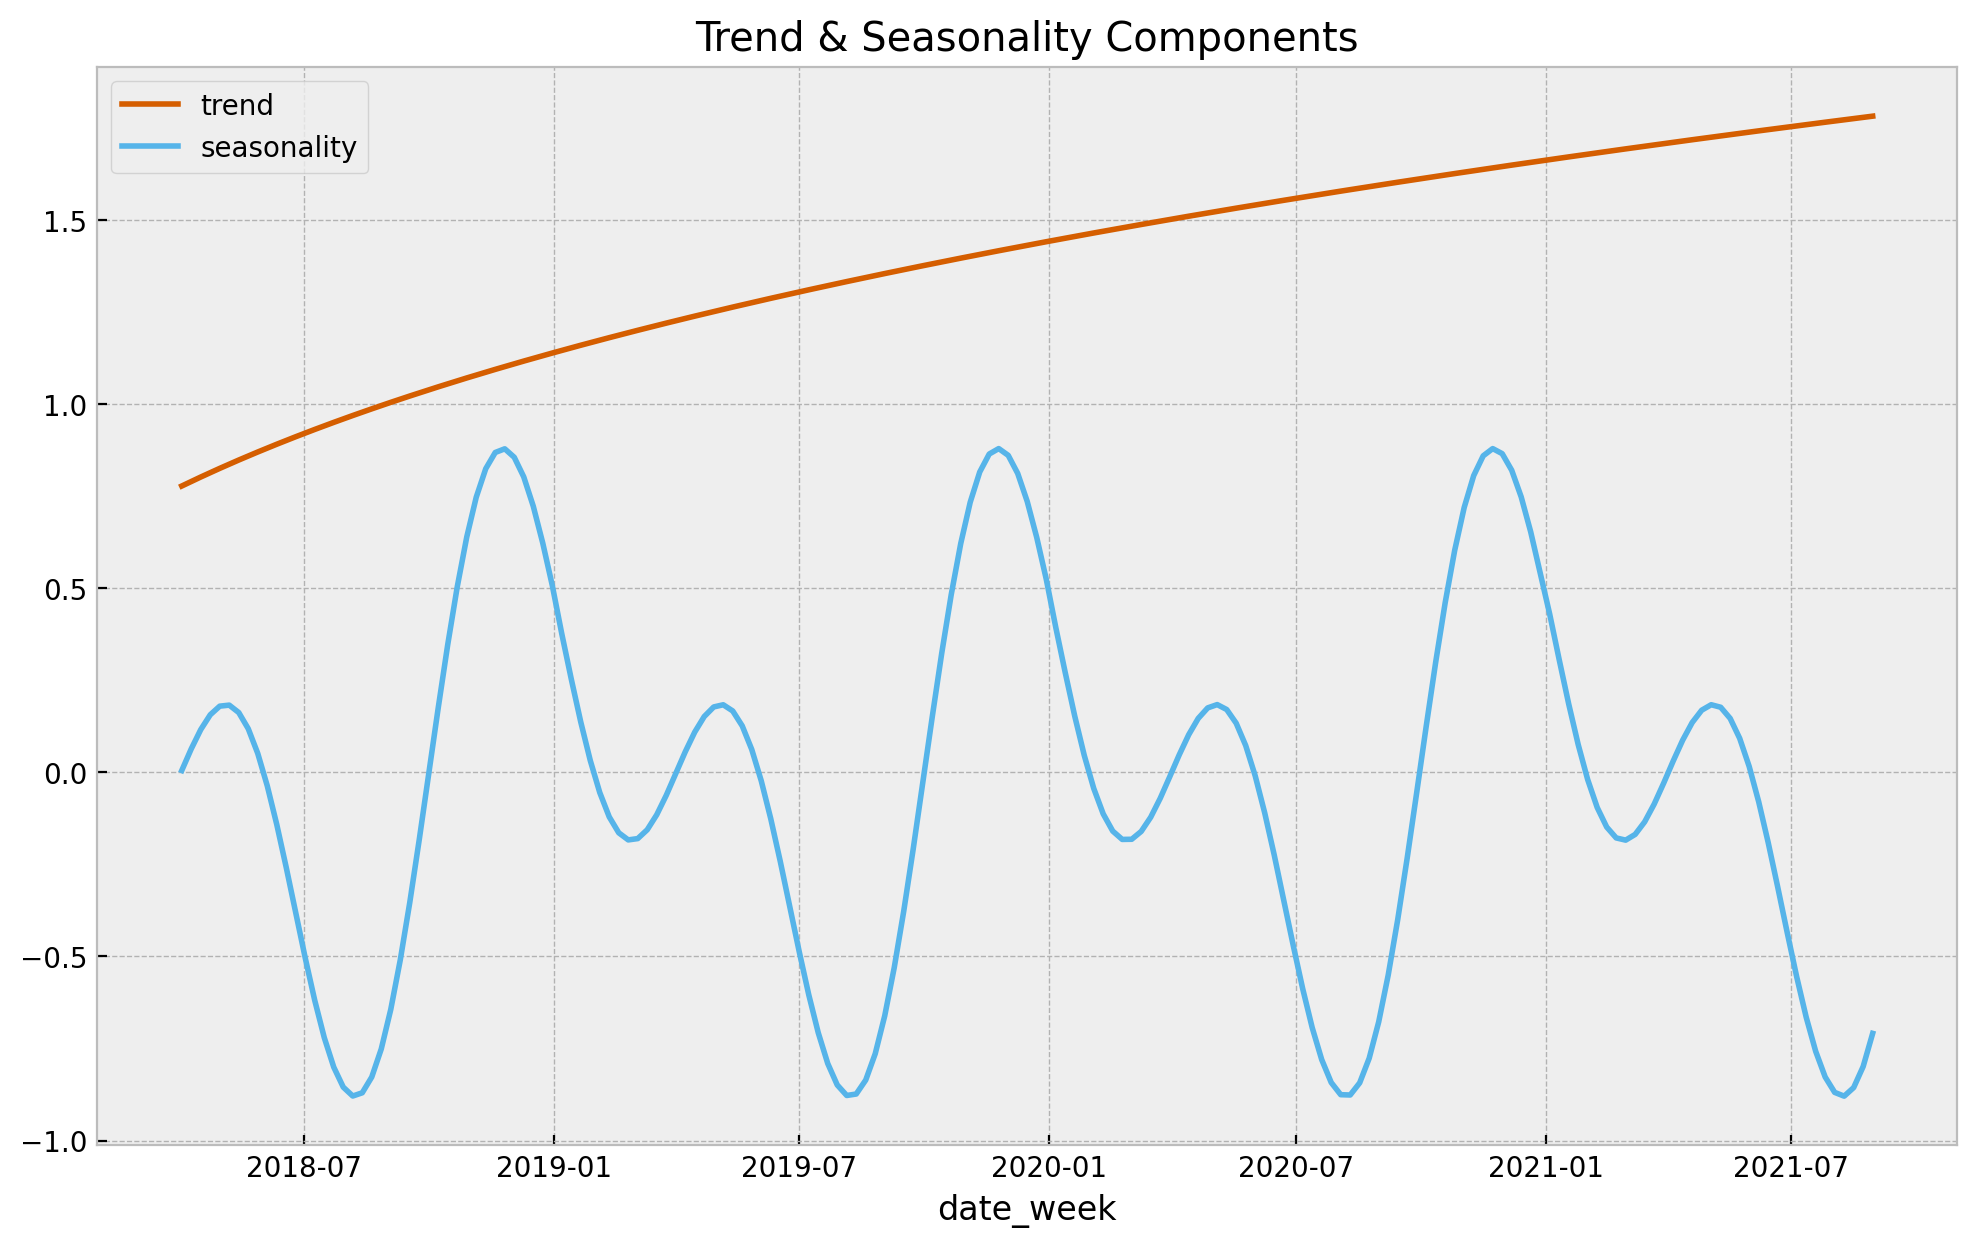

In [6]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = - np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5) 
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C4", label="trend", data=df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C6", label="seasonality", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel=None);

### Control Variables

In [7]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

### Target Variable

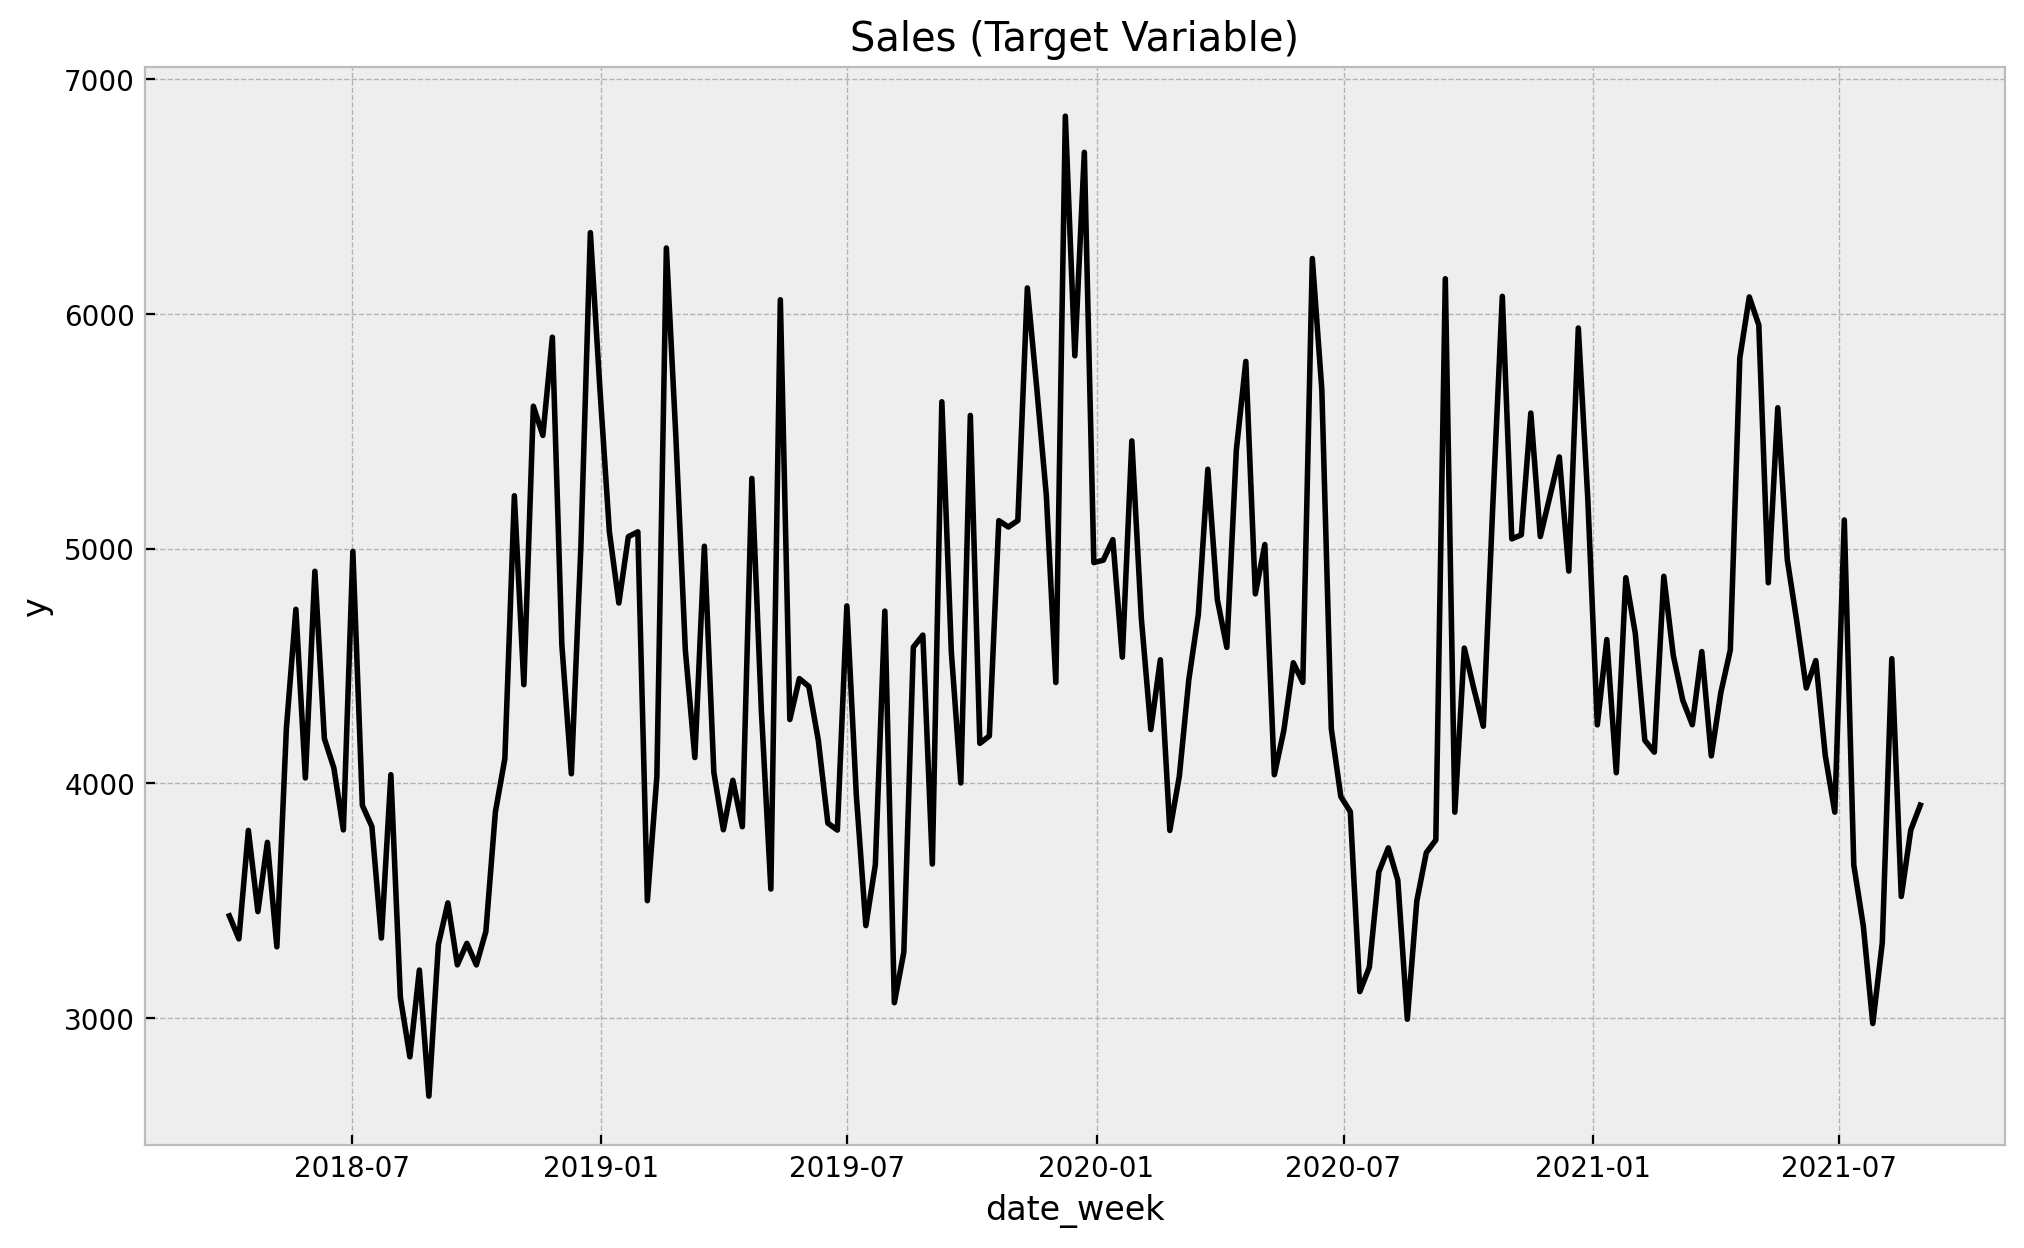

In [8]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.2, size=n)

df["y"] = 1_000 * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + 3 * df["z1_adstock_saturated"]
    + 2 * df["z2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)");

---

# Part II: Modeling

In [9]:
columns_to_keep = [
    "date_week",
    "y",
    "z1",
    "z2",
    "event_1",
    "event_2",
]

fourier_modes = generate_fourier_modes(
    periods=df["date_week"].dt.dayofyear / 365.25,
    n_order=2
)

data_df = pd.concat([df[columns_to_keep], fourier_modes], axis=1)

data_df.head()

date_week            y        z1   z2  event_1  event_2  sin_order_1  \
0 2018-04-02  3435.582052  0.318580  0.0      0.0      0.0     0.999930   
1 2018-04-09  3337.626383  0.112388  0.0      0.0      0.0     0.991269   
2 2018-04-16  3799.990291  0.292400  0.0      0.0      0.0     0.968251   
3 2018-04-23  3453.806977  0.071399  0.0      0.0      0.0     0.931210   
4 2018-04-30  3749.062649  0.386745  0.0      0.0      0.0     0.880683   

   cos_order_1  sin_order_2  cos_order_2  
0    -0.011826    -0.023651    -0.999720  
1    -0.131859    -0.261414    -0.965227  
2    -0.249981    -0.484089    -0.875019  
3    -0.364483    -0.678820    -0.734304  
4    -0.473706    -0.834370    -0.551205

In [10]:
mmm = DelayedSaturatedMMM(
    data_df=data_df,
    target_column="y",
    date_column="date_week",
    channel_columns=["z1", "z2"],
    control_columns=[
        "event_1",
        "event_2",
        "sin_order_1",
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=8,
)

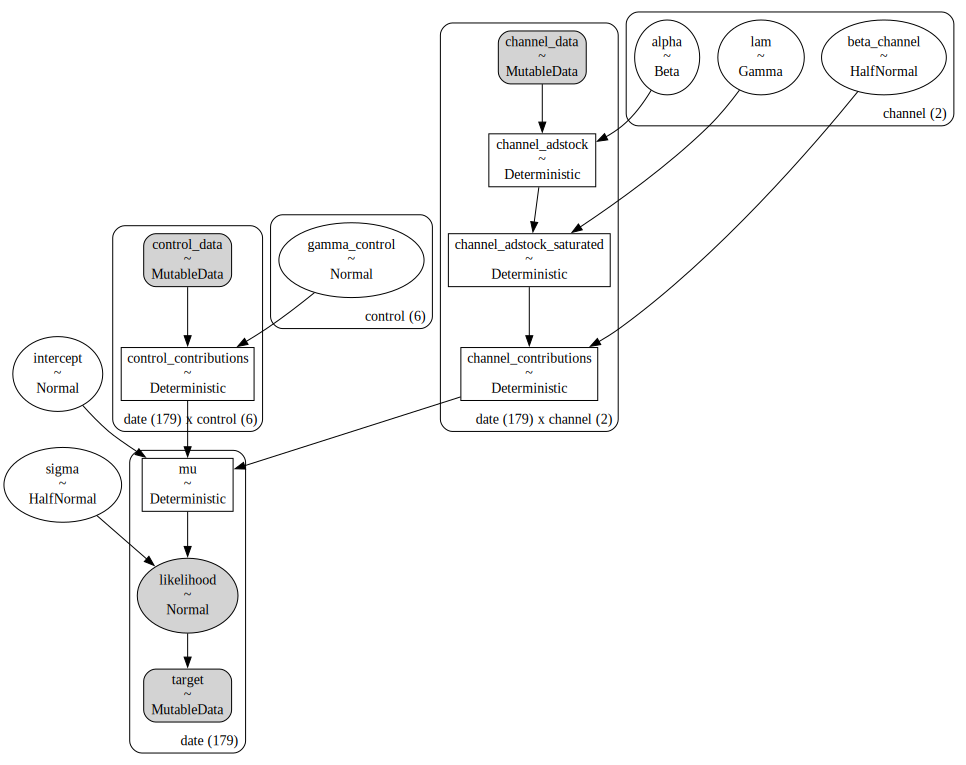

In [11]:
pm.model_to_graphviz(model=mmm.model)

In [12]:
mmm.fit(target_accept=0.95, chains=4, draws=1_000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
Sampling: [likelihood]


In [13]:
az.summary(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept         0.206  0.024   0.160    0.250      0.000    0.000    2377.0   
beta_channel[z1]  0.470  0.137   0.326    0.655      0.004    0.003    1838.0   
beta_channel[z2]  0.543  0.372   0.223    1.150      0.012    0.009    1137.0   
alpha[z1]         0.266  0.065   0.145    0.387      0.001    0.001    3518.0   
alpha[z2]         0.235  0.070   0.095    0.353      0.001    0.001    2323.0   
lam[z1]           2.788  0.780   1.299    4.242      0.019    0.013    1756.0   
lam[z2]           2.288  1.311   0.281    4.591      0.034    0.024    1154.0   
gamma_control[0]  0.416  0.080   0.270    0.566      0.001    0.001    4634.0   
gamma_control[1]  0.700  0.079   0.546    0.841      0.001    0.001    4111.0   
gamma_control[2]  0.016  0.009  -0.001    0.032      0.000    0.000    4627.0   
gamma_control[3]  0.126  0.008   0.111    0.142      0.000    0.000    4841.0   
gamma_control[4] -0.102  0.008  -0.118   -0.087      0.000    0.000    4050.0   
gamma_control[5]  0.017  0.009   0.001    0.033      0.000    0.000    4364.0   
sigma             0.078  0.004   0.070    0.086      0.000    0.000    4649.0   

                  ess_tail  r_hat  
intercept           2890.0    1.0  
beta_channel[z1]    1069.0    1.0  
beta_channel[z2]    1310.0    1.0  
alpha[z1]           2206.0    1.0  
alpha[z2]           2084.0    1.0  
lam[z1]             1001.0    1.0  
lam[z2]             1340.0    1.0  
gamma_control[0]    2508.0    1.0  
gamma_control[1]    2976.0    1.0  
gamma_control[2]    2860.0    1.0  
gamma_control[3]    2878.0    1.0  
gamma_control[4]    2947.0    1.0  
gamma_control[5]    2816.0    1.0  
sigma               2606.0    1.0

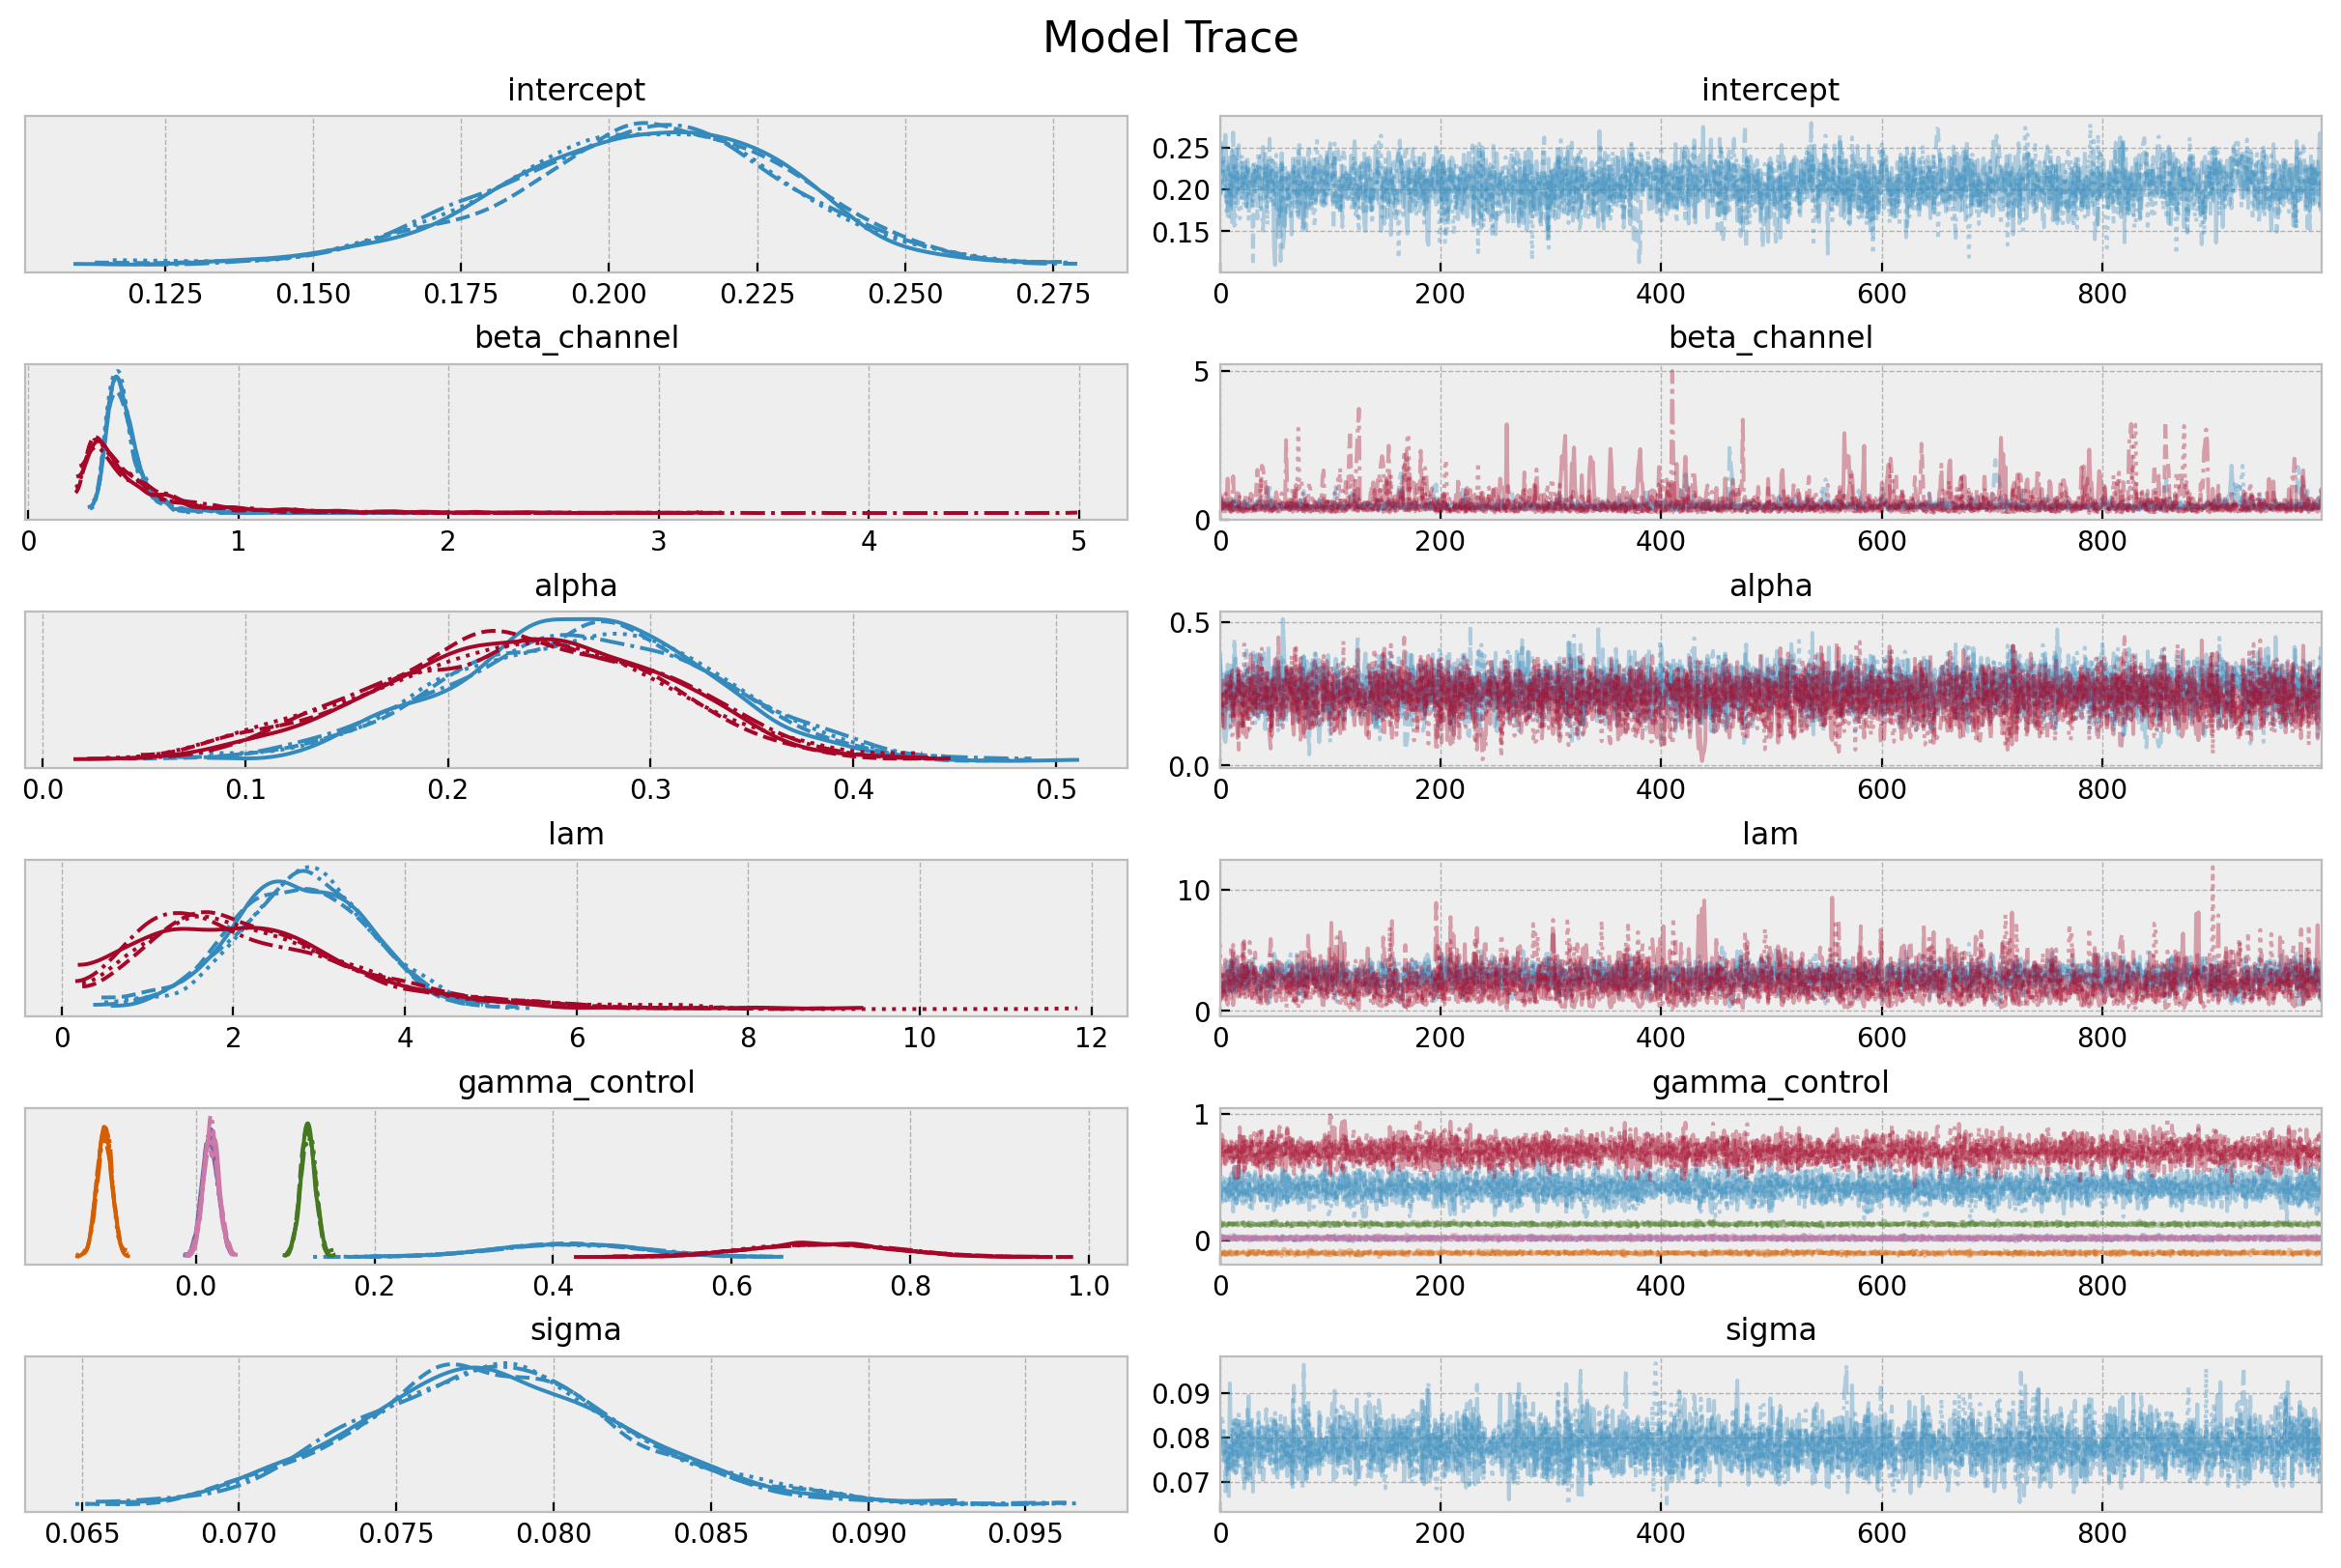

In [14]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "lam", "gamma_control", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

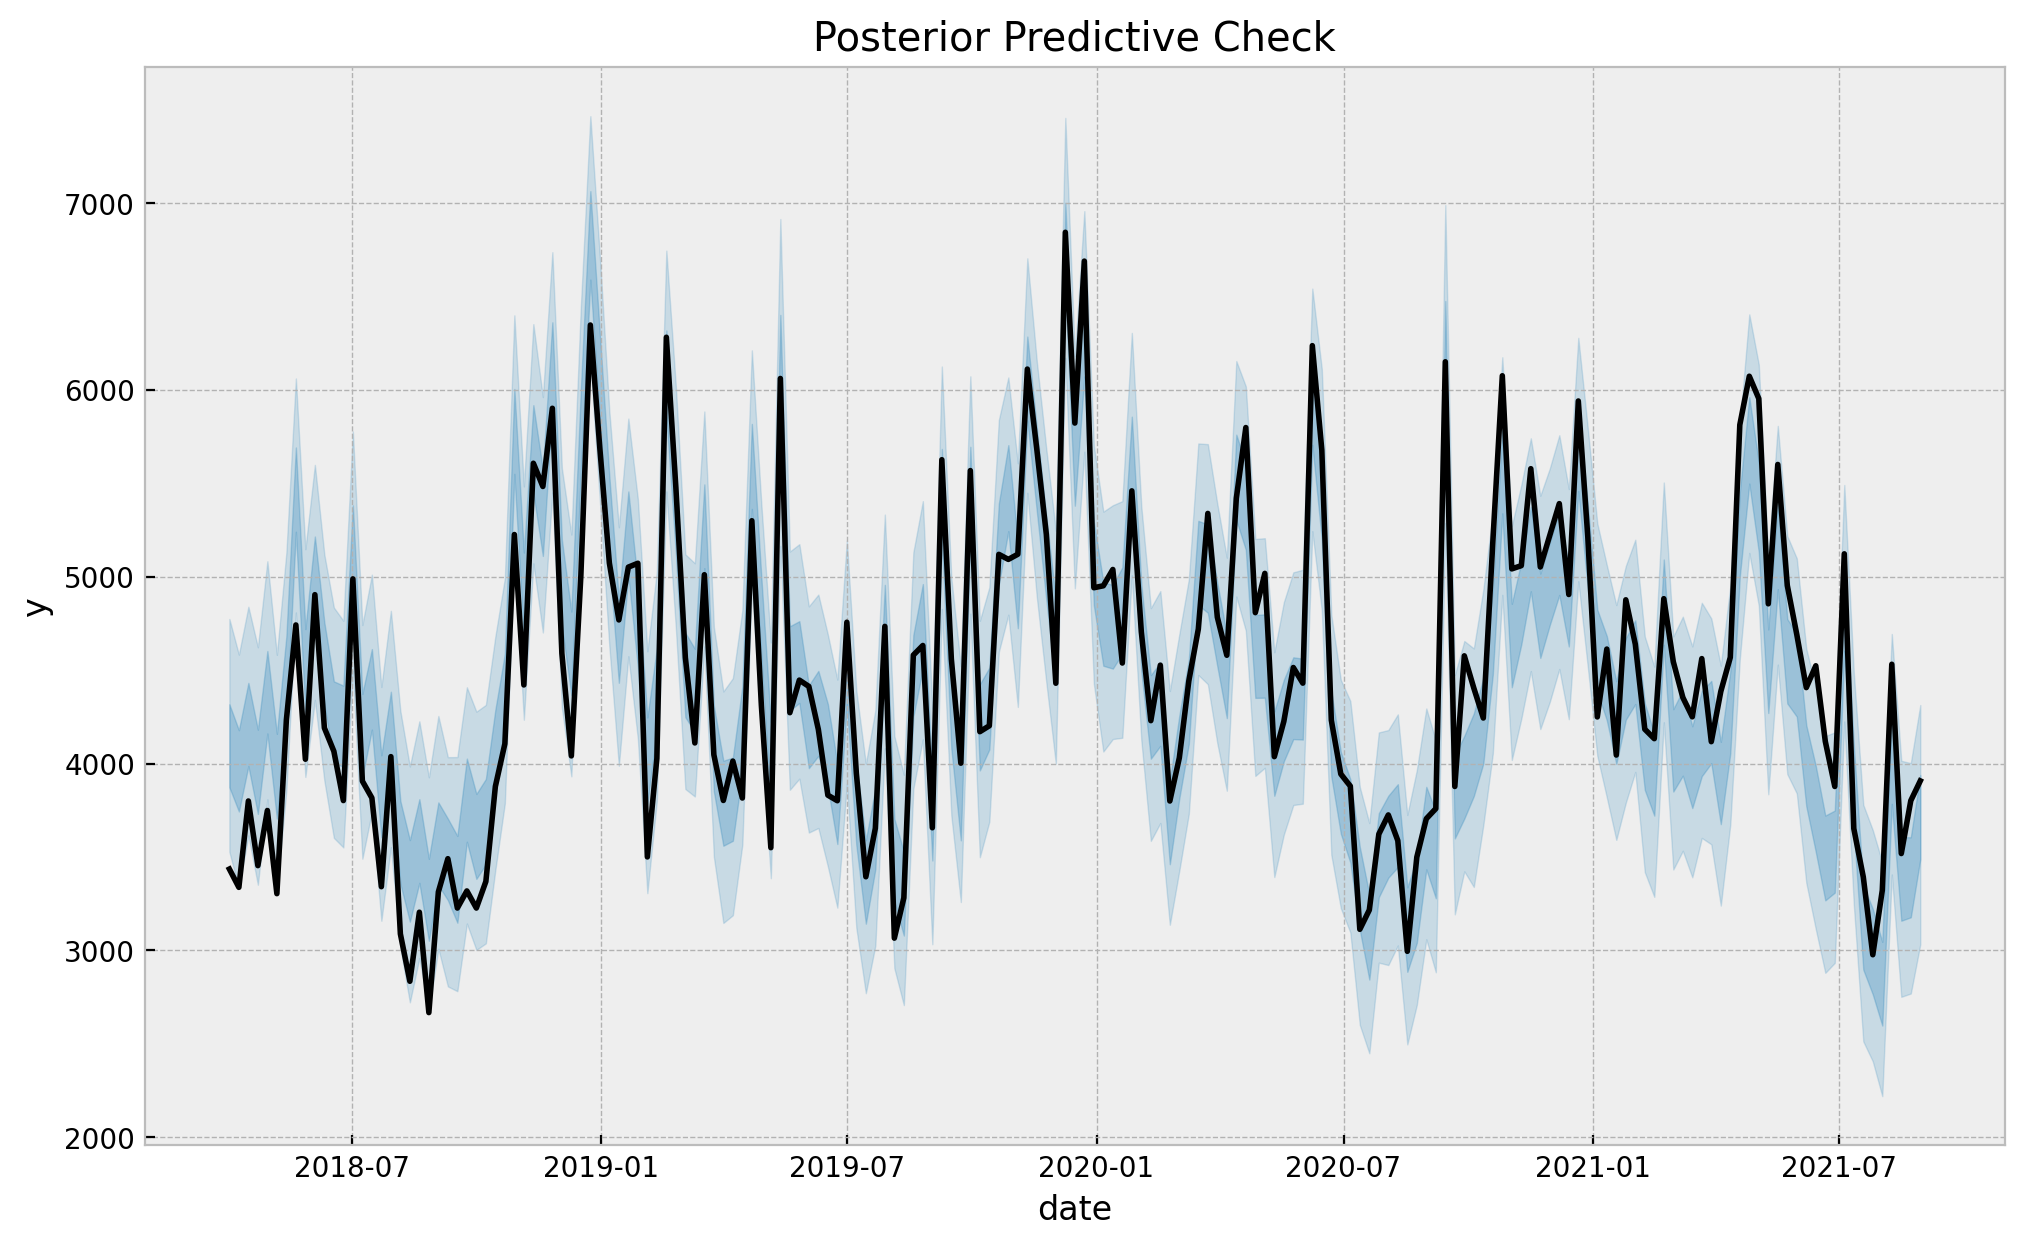

In [15]:
mmm.plot_posterior_predictive(original_scale=True);

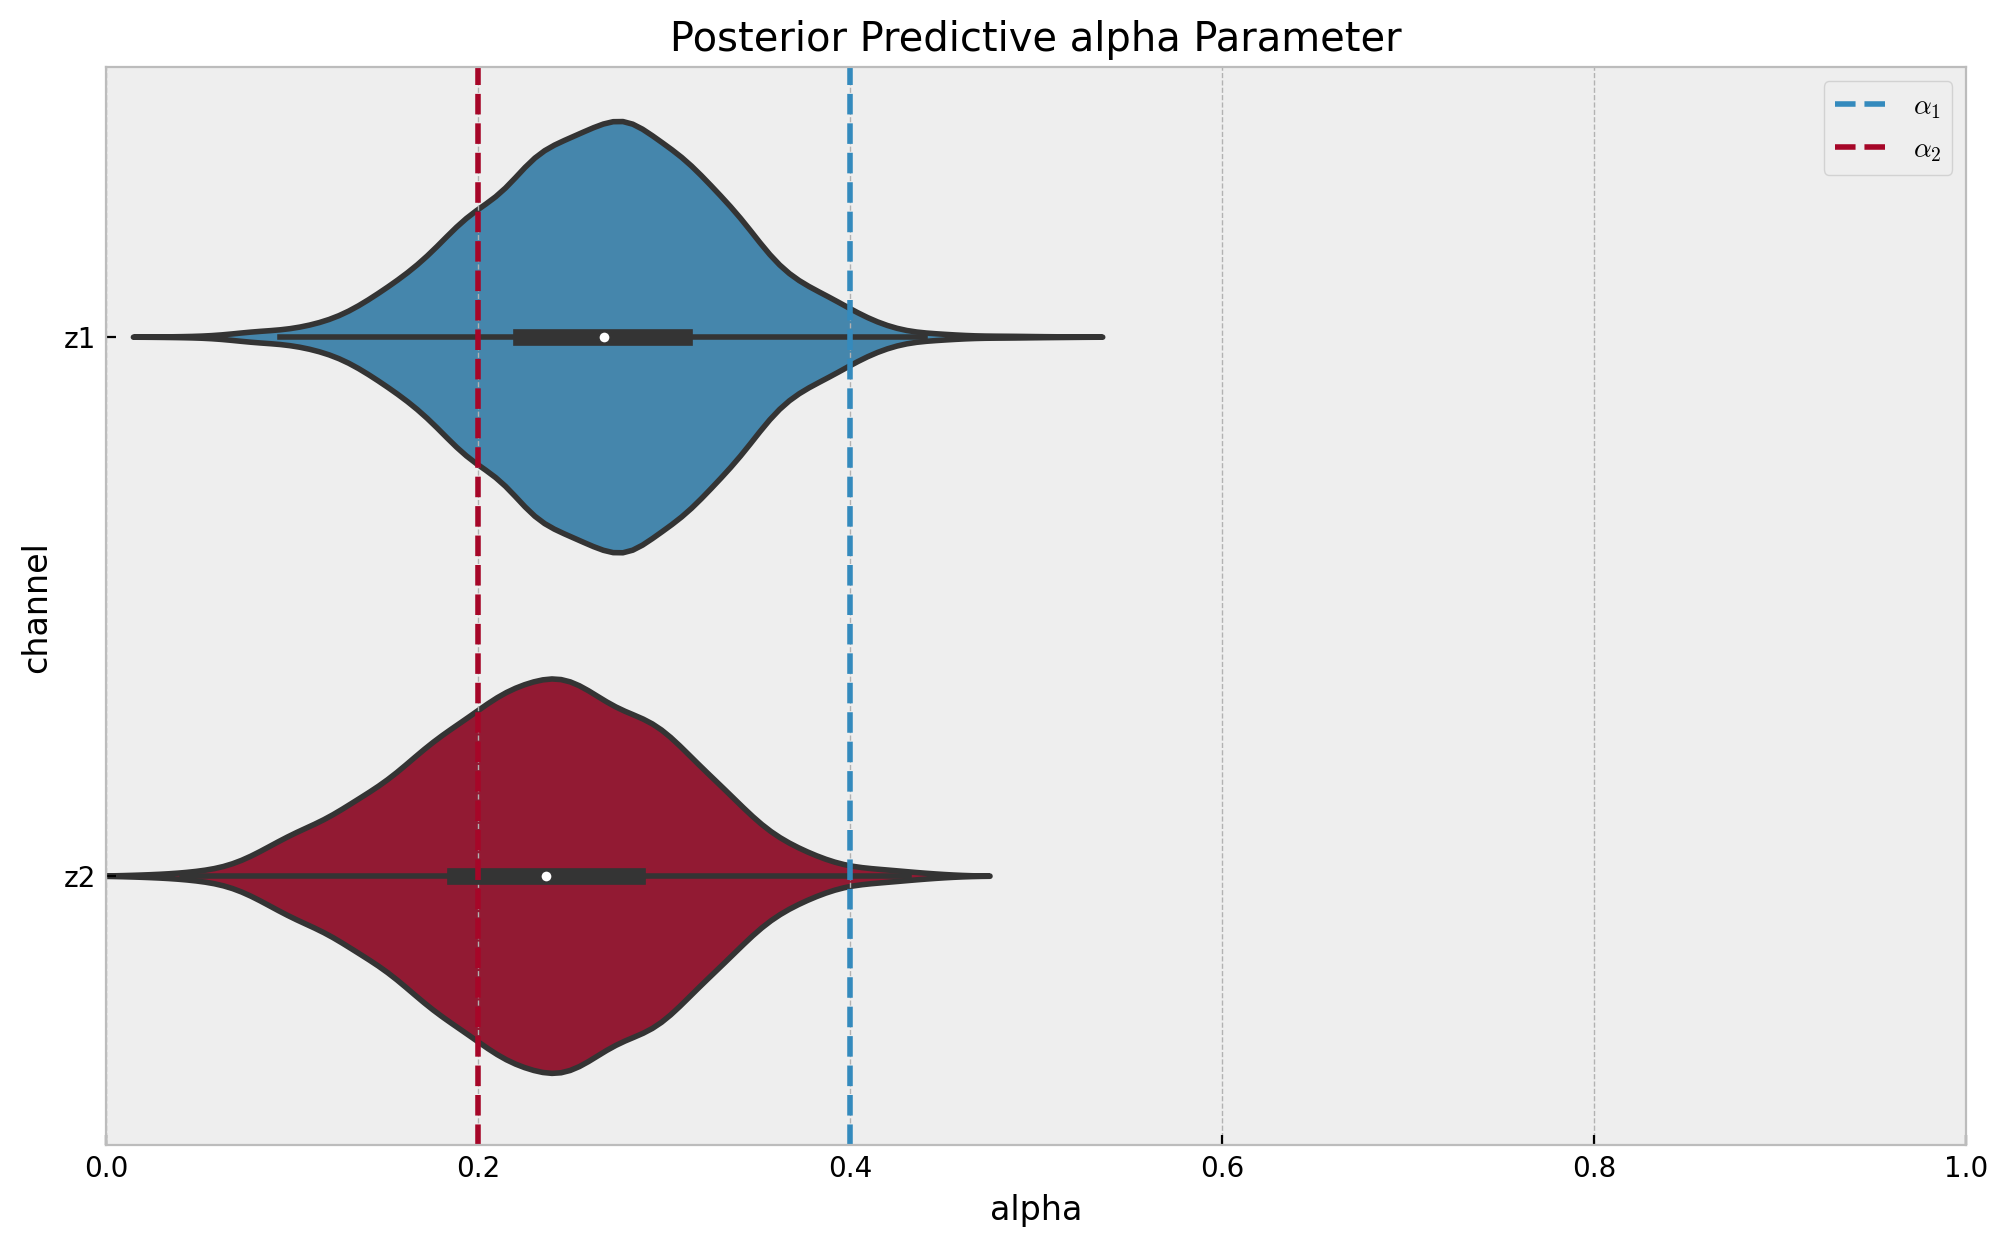

In [54]:
fig = mmm.plot_channel_parameter(param_name="alpha")
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right")
ax.set(xlim=(0, 1.0));

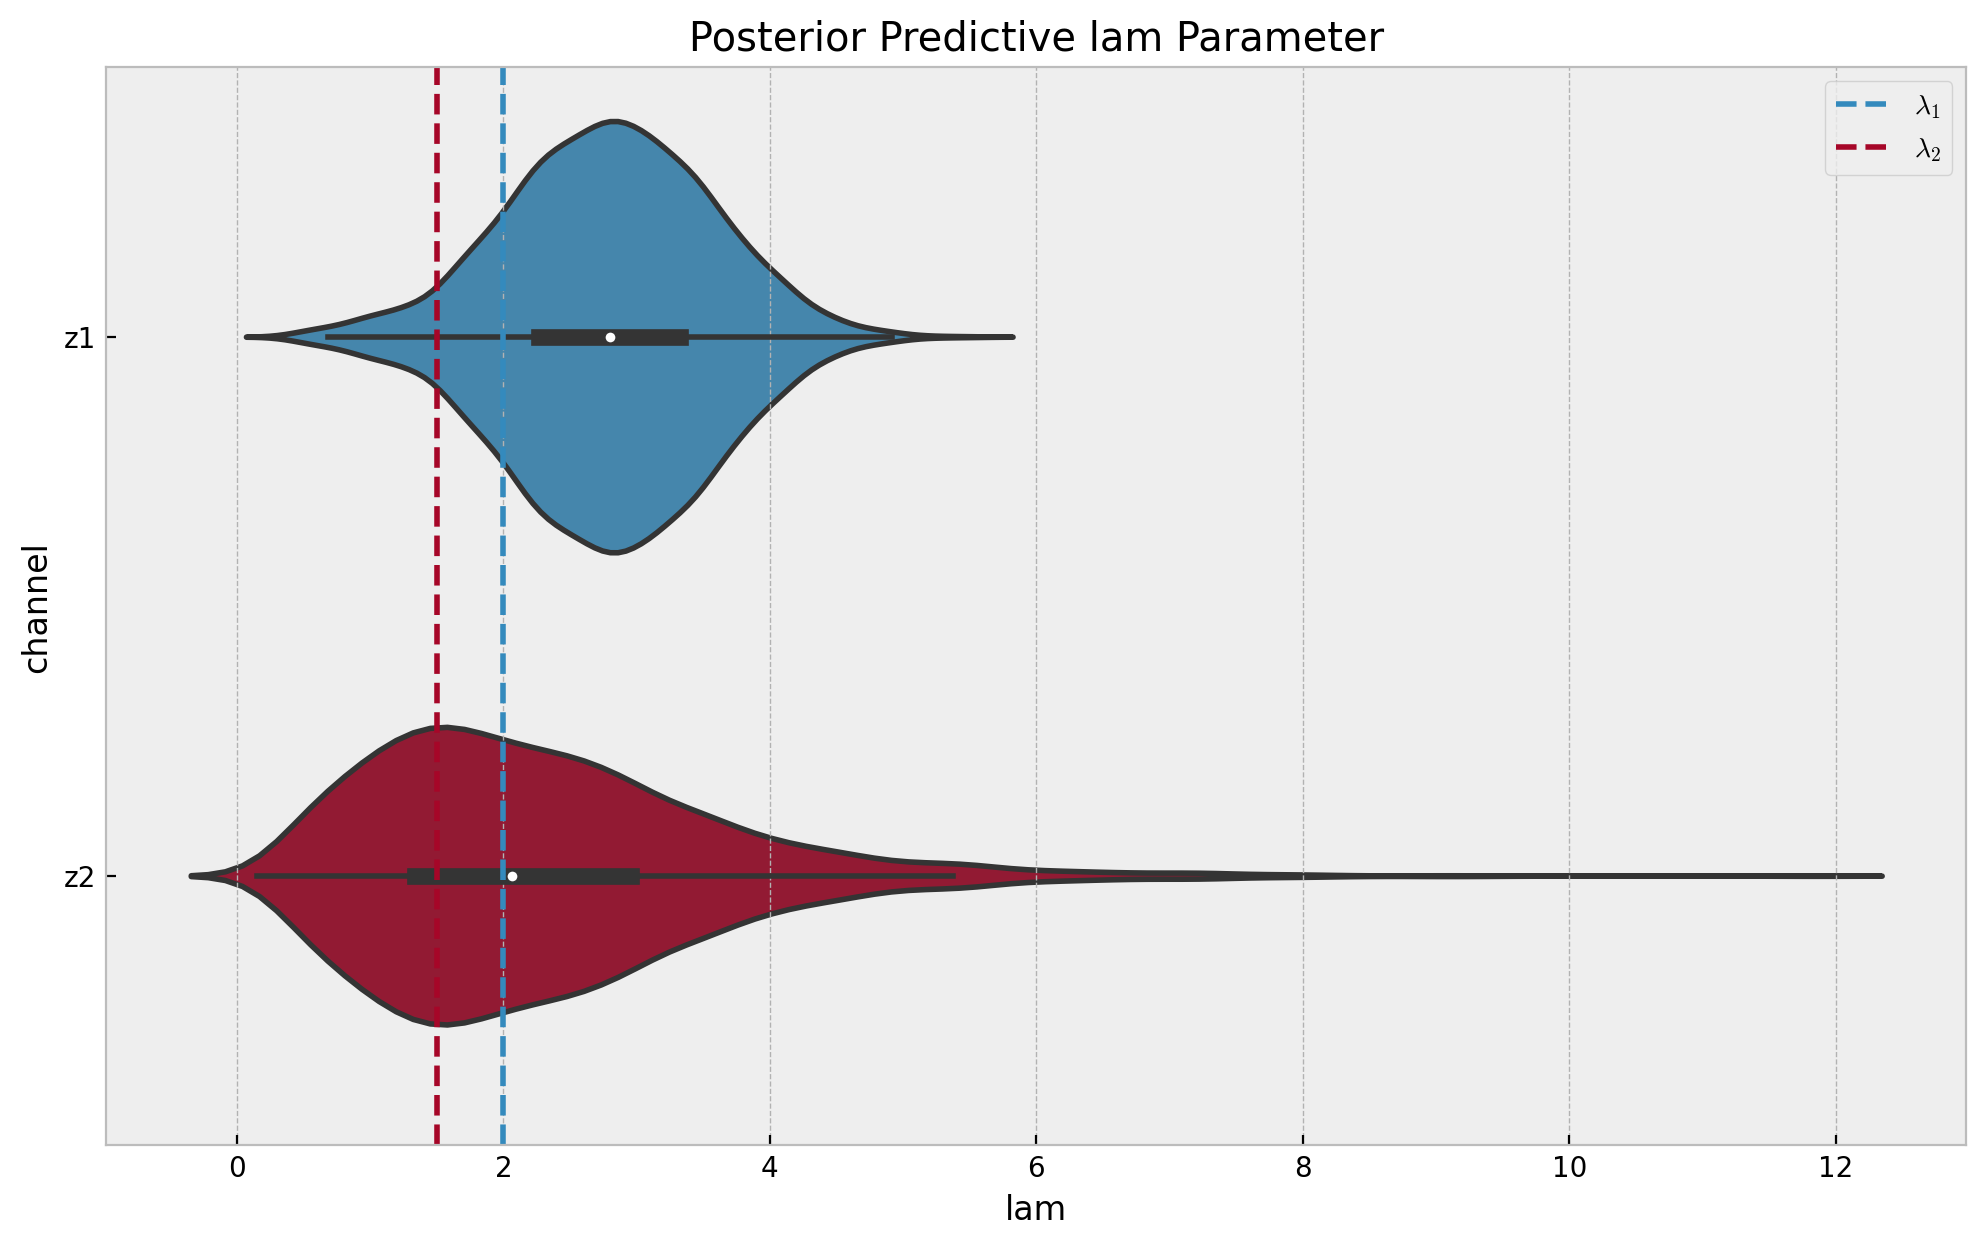

In [18]:
fig = mmm.plot_channel_parameter(param_name="lam")
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

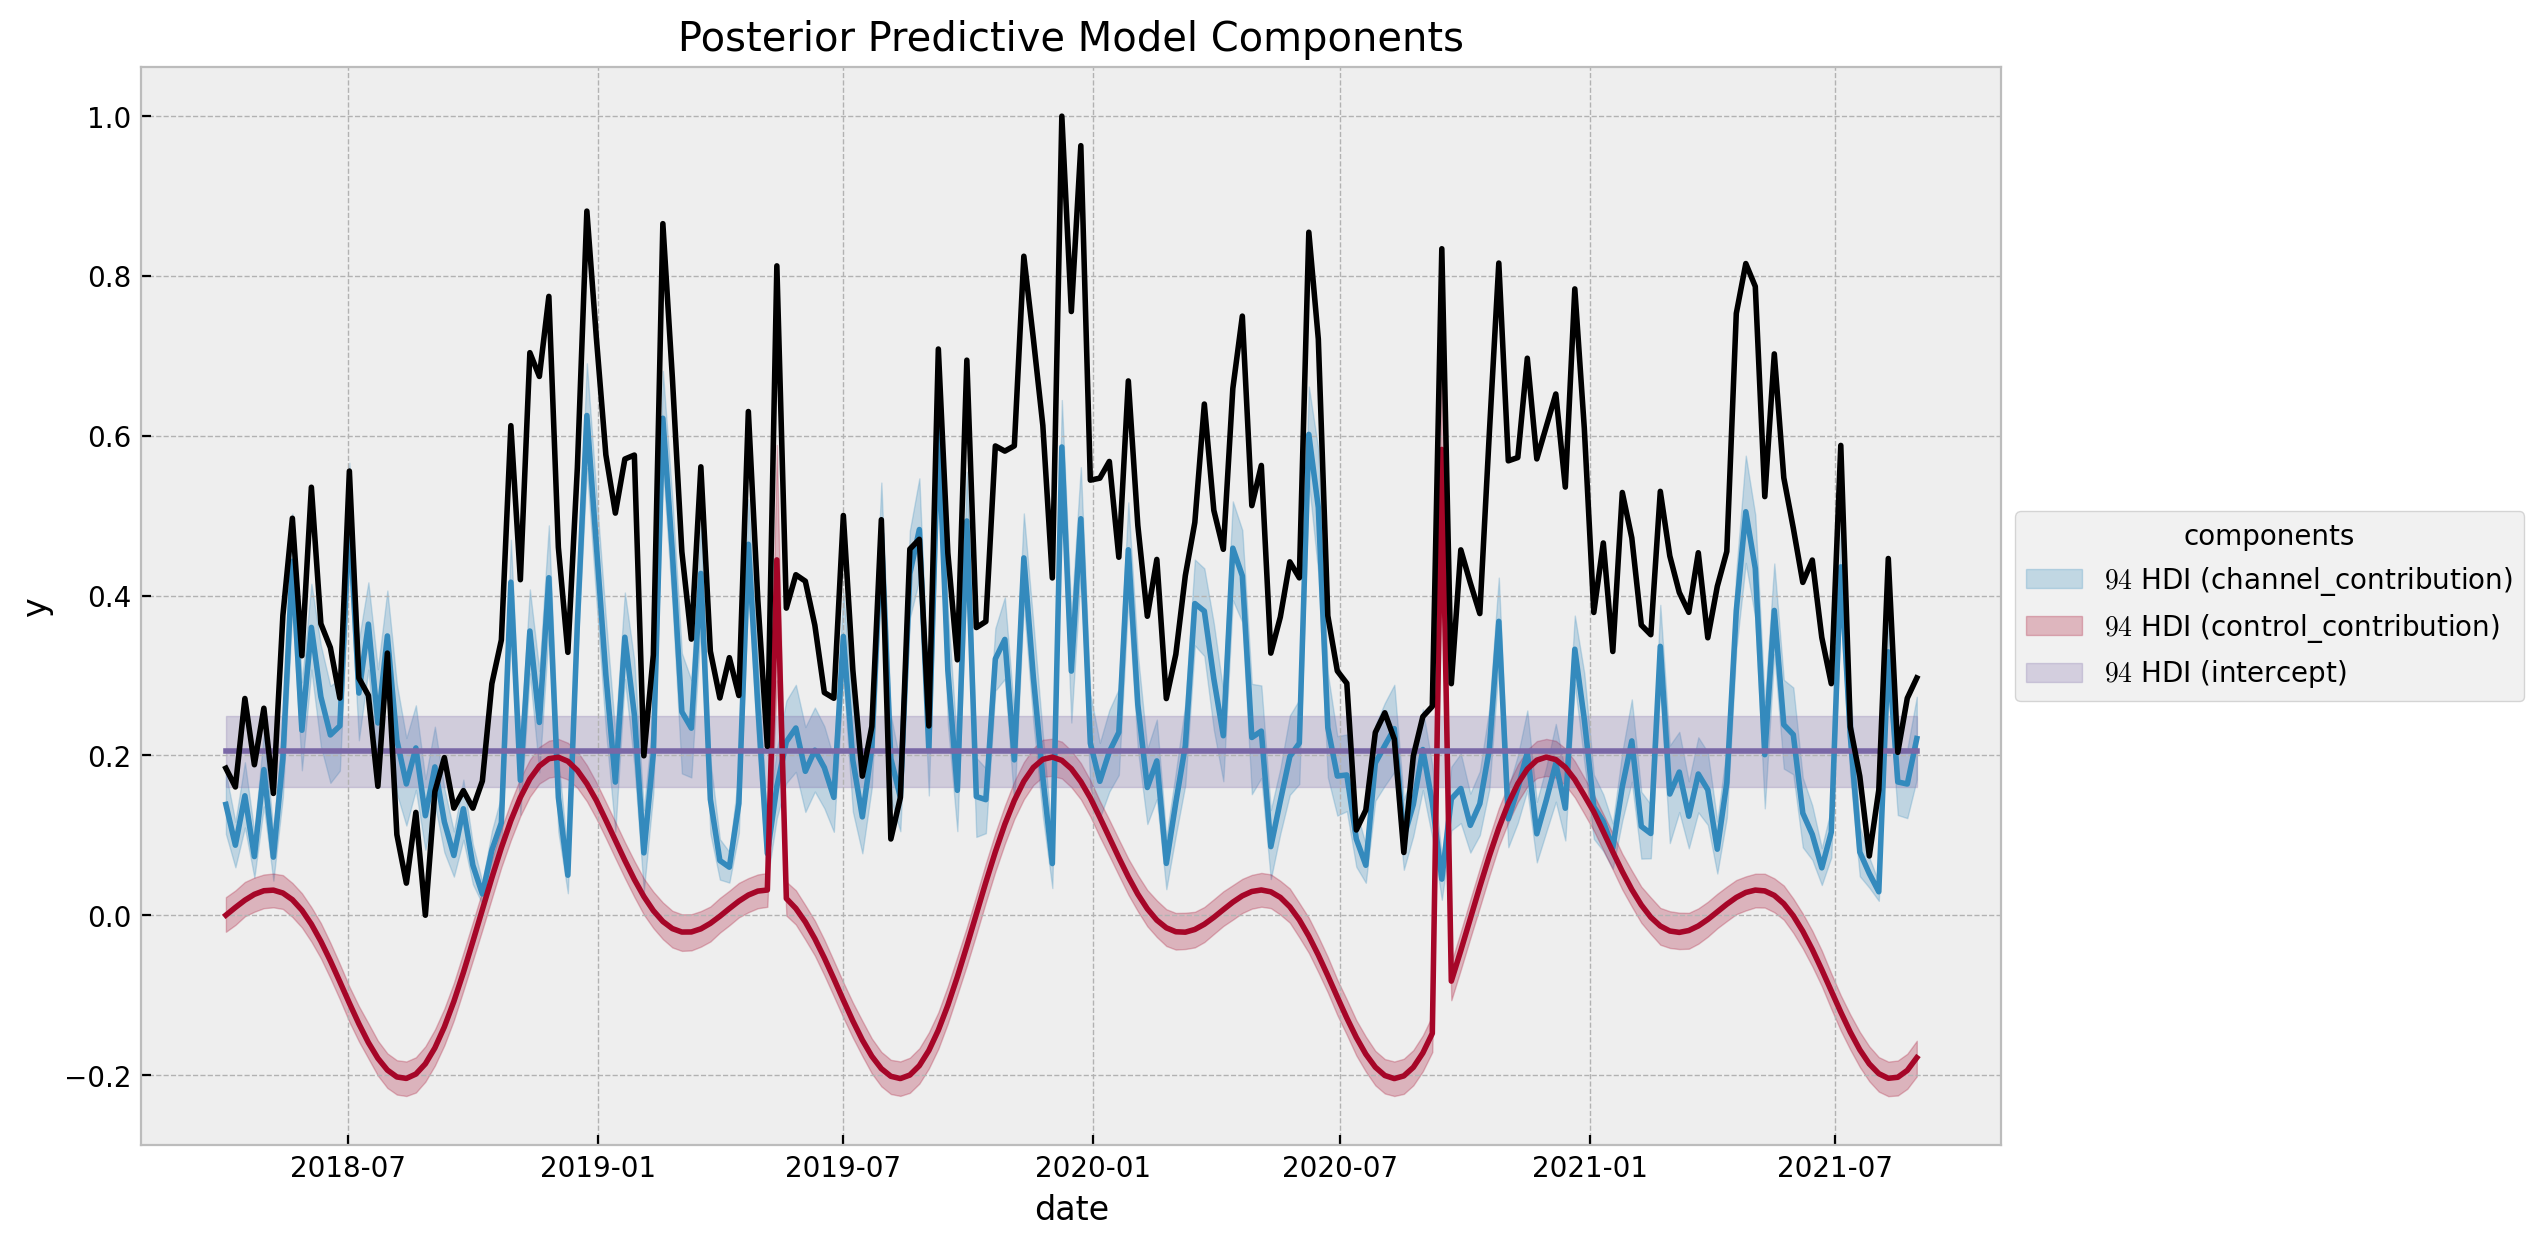

In [19]:
mmm.plot_components_contributions();

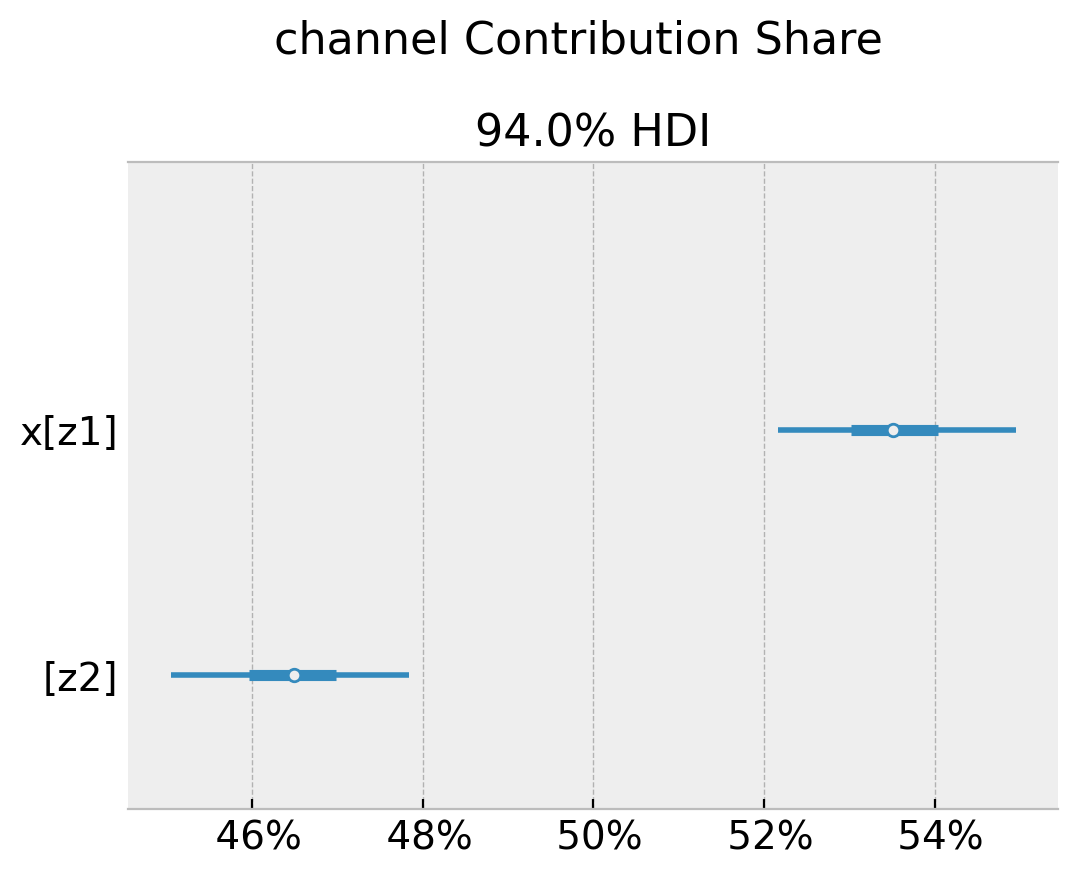

In [20]:
mmm.plot_channel_contribution_share_hdi();

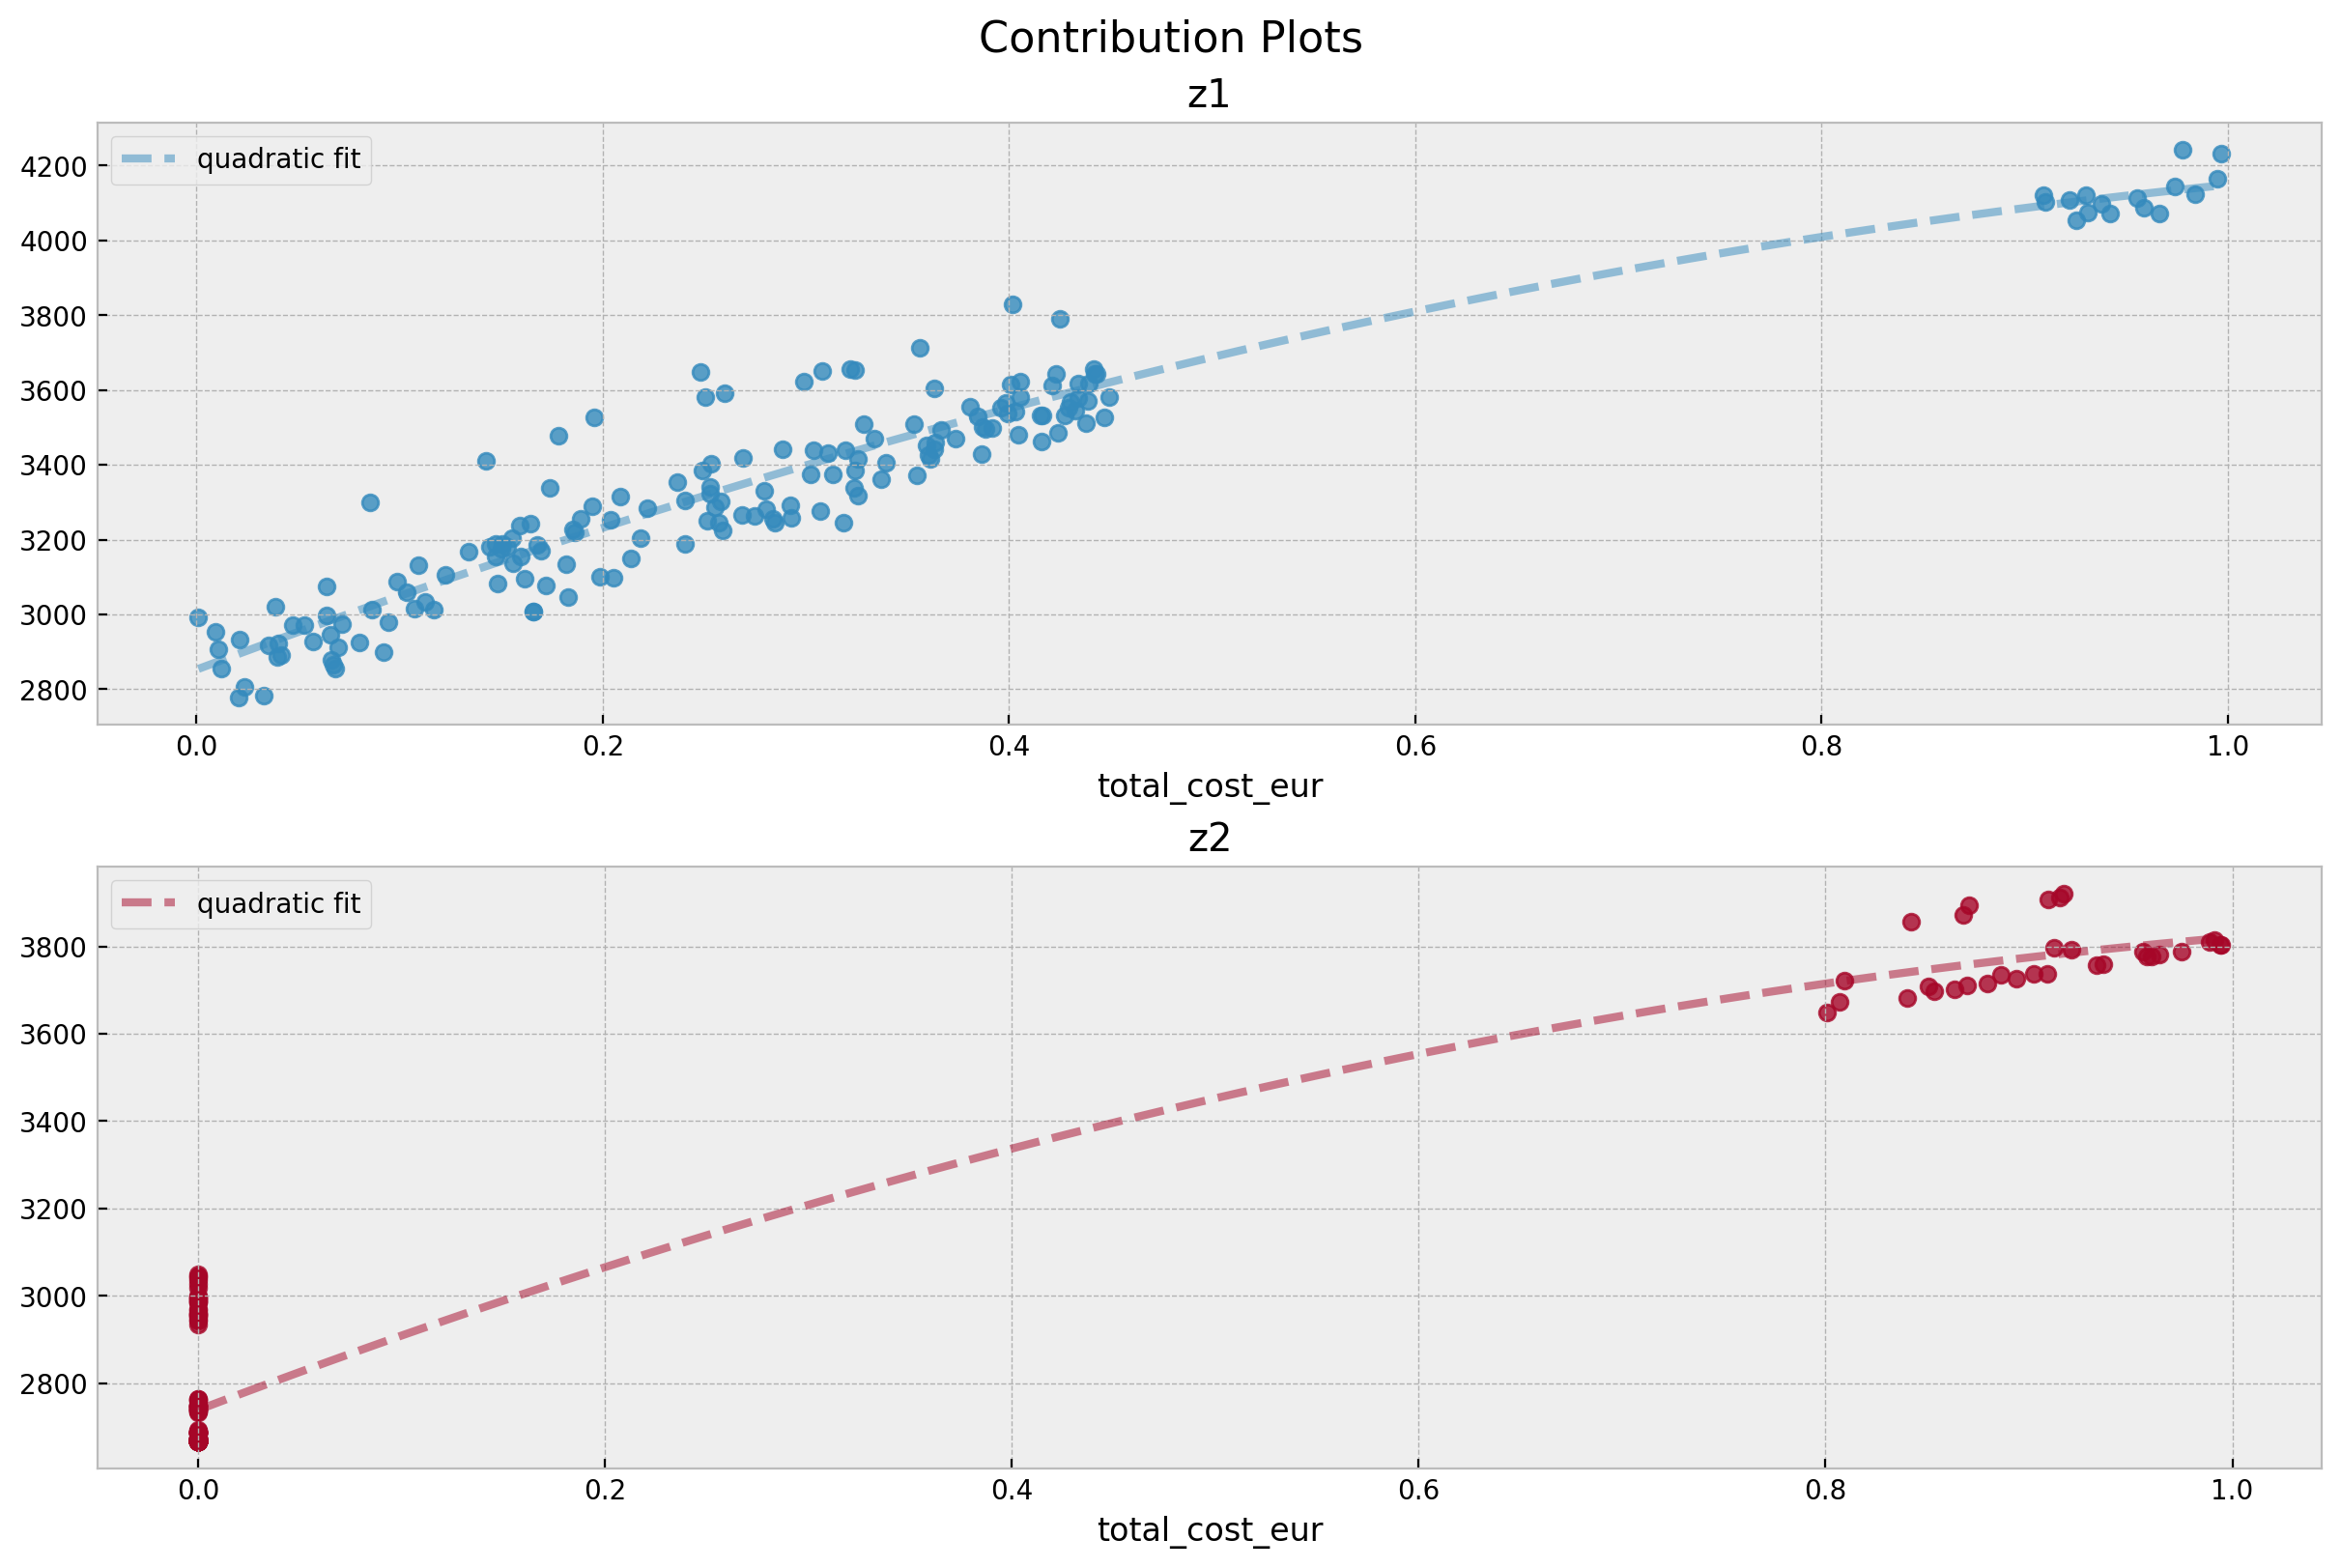

In [21]:
mmm.plot_contribution_curves();

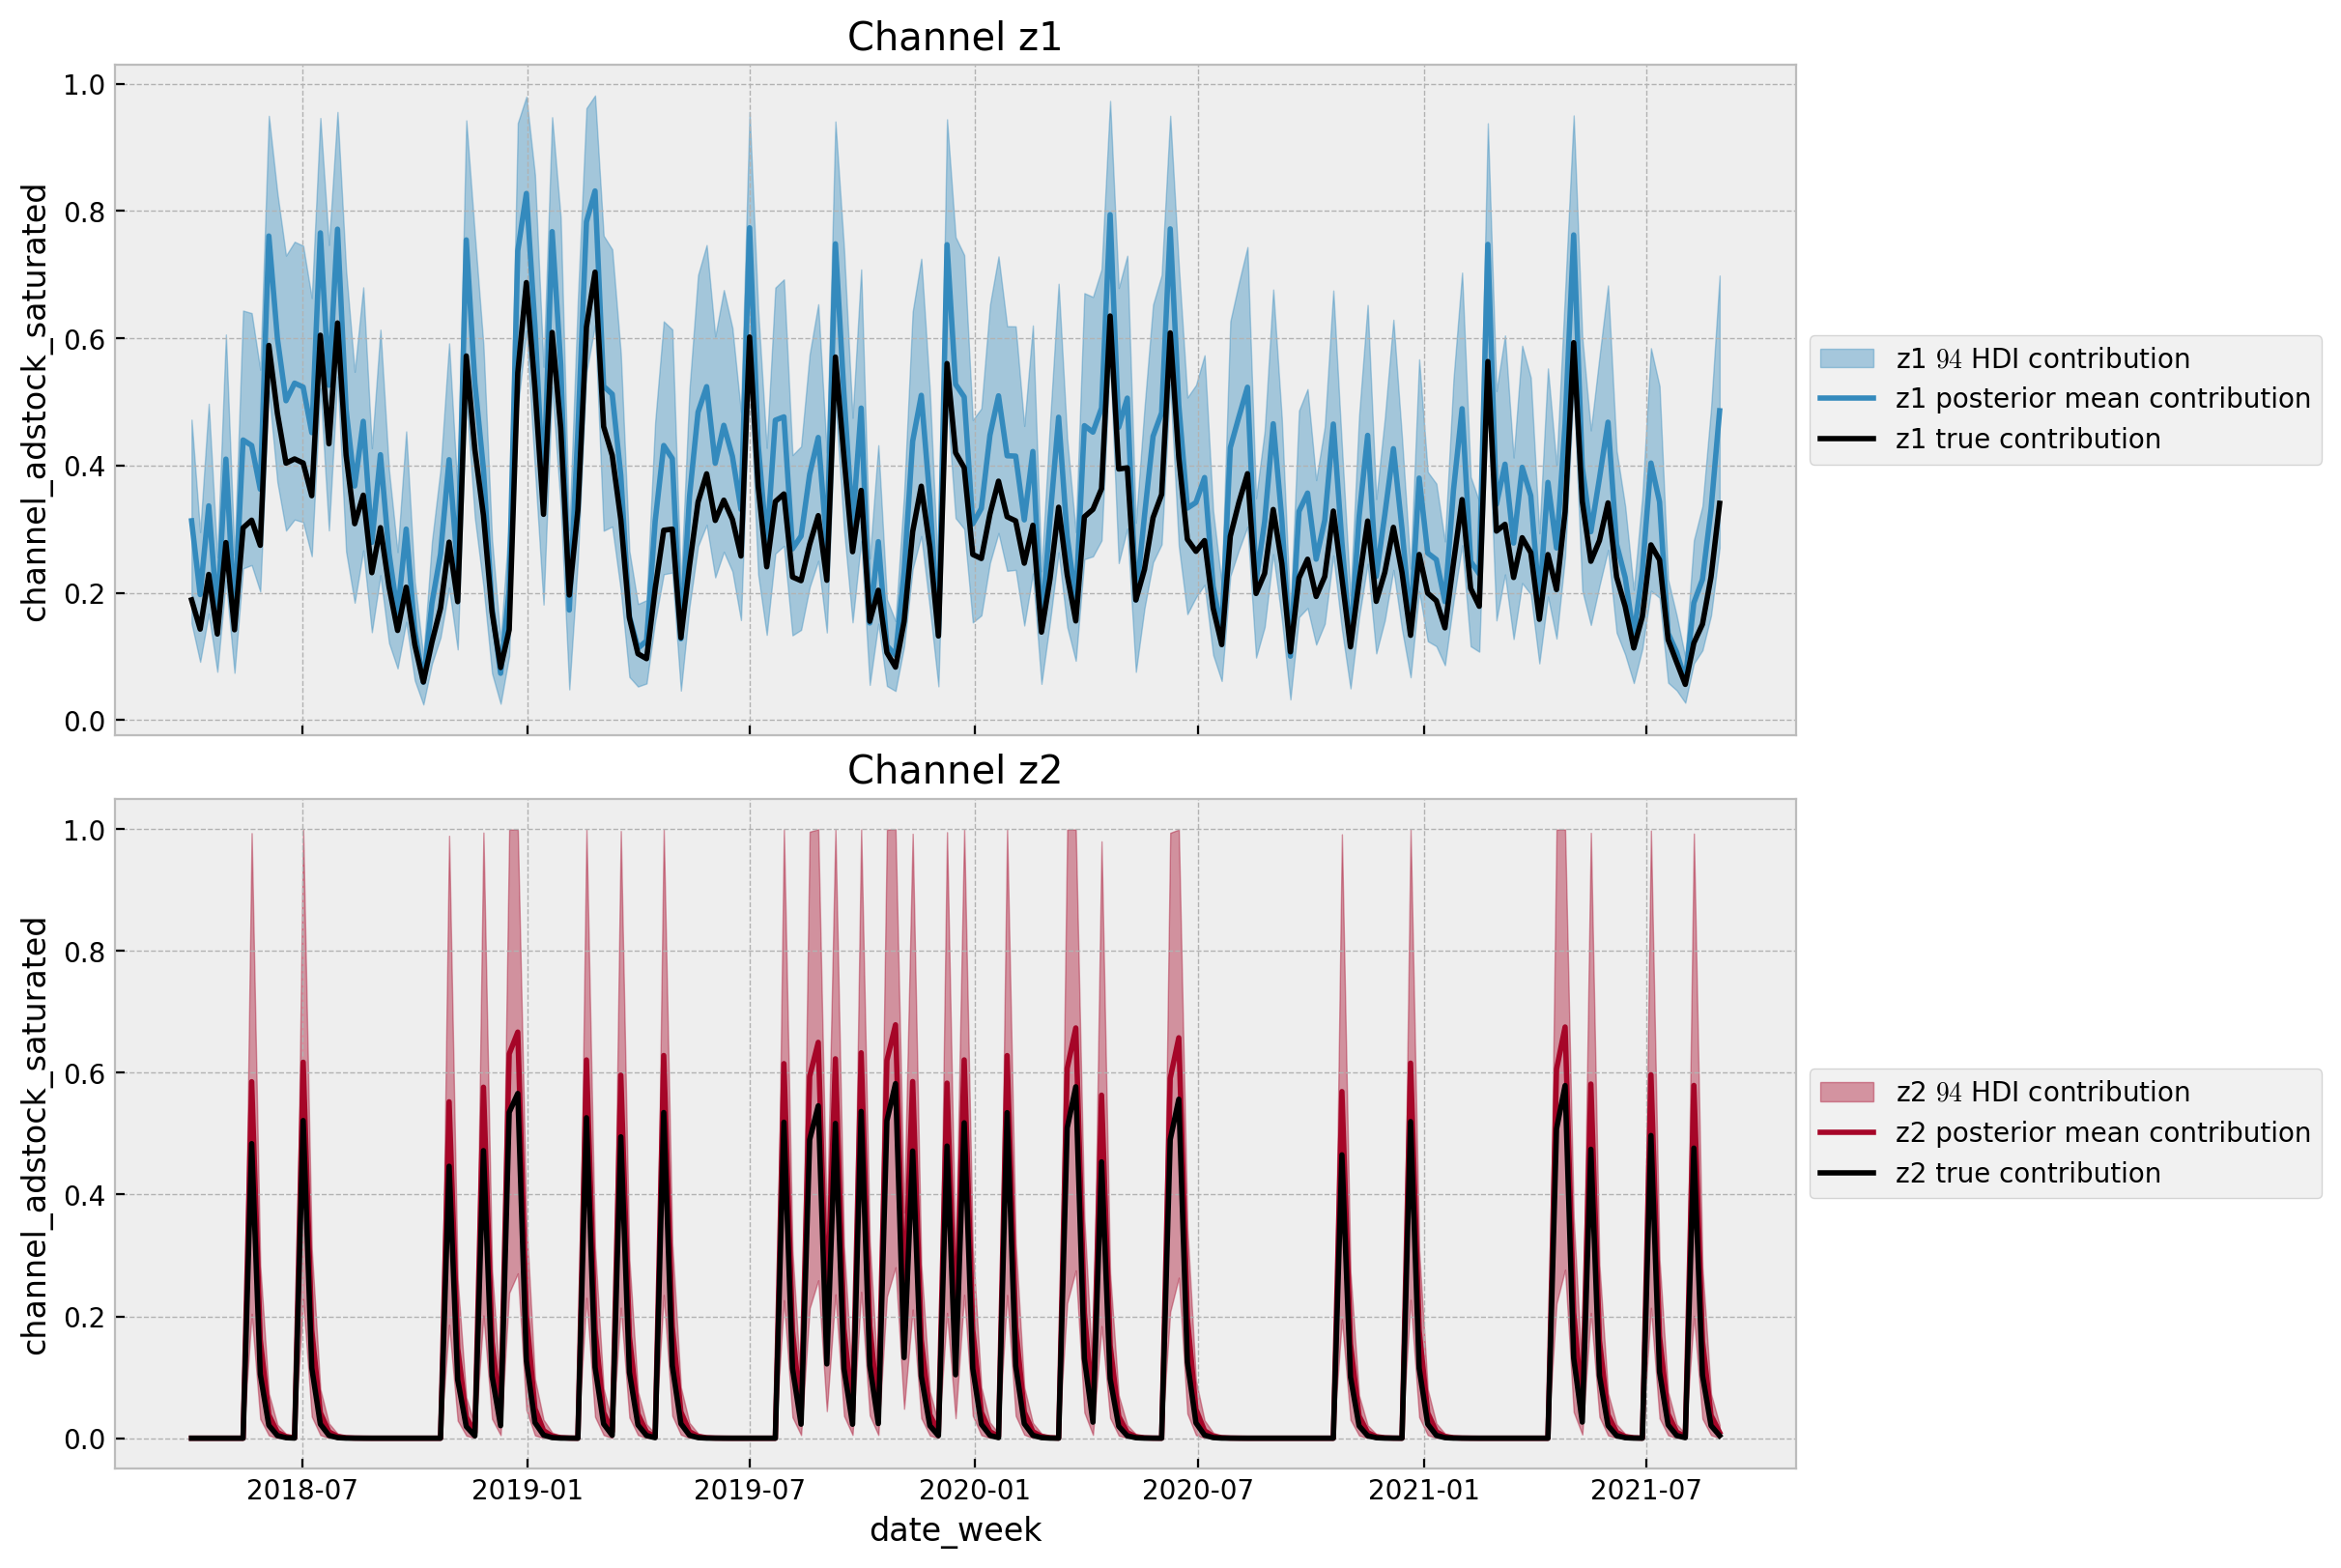

In [51]:
estimated_channels_contribution_hdi = az.hdi(ary=mmm.fit_result)["channel_adstock_saturated"]

fig, ax = plt.subplots(
    nrows=2, figsize=(12, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, z, in enumerate(["z1", "z2"]):
    ax[i].fill_between(
        x=df["date_week"],
        y1=estimated_channels_contribution_hdi[:, i, 0],
        y2=estimated_channels_contribution_hdi[:, i, 1],
        color=f"C{i}",
        label=f"{z} $94%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x=df["date_week"],
        y=az.extract(
            data=mmm.fit_result,
            group="posterior",
            var_names=["channel_adstock_saturated"]
        ).mean("sample")[:, i],
        color=f"C{i}",
        label=f"{z} posterior mean contribution",
        ax=ax[i]
    )
    sns.lineplot(
        x="date_week",
        y=f"{z}_adstock_saturated",
        data=df, color="black",
        label=f"{z} true contribution",
        ax=ax[i]
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {z}")